### general imports

In [2]:
import os, sys    # for handling paths
import h5py as h5  #for handling data format
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import Image
from scipy.stats import gaussian_kde
from astropy import units as u

In [3]:
# set path to data file
path = '/home/louism/Thesis/data/COMPAS_Output_16/COMPAS_Output.h5'

# load the file
data = h5.File(path)

# inspect the data
list(data.keys())

['BSE_Common_Envelopes',
 'BSE_Double_Compact_Objects',
 'BSE_RLOF',
 'BSE_Supernovae',
 'BSE_Switch_Log',
 'BSE_System_Parameters',
 'Run_Details']

In [4]:
SLs = data['BSE_Switch_Log']
SPs = data['BSE_System_Parameters']
RLOF = data['BSE_RLOF']
CEs = data['BSE_Common_Envelopes']

In [5]:
kg = ( 1.988416 * 10**(30) )**(-1) # in solar mass
g = ( 1.988416 * 10**(33) )**(-1) # in solar mass

m = ( 6.957 * 10**(8) )**(-1) # in solar radii
cm = ( 6.957 * 10**(10) )**(-1) # in solar radii

s = ( 86400 )**(-1) # in days

G =  6.67430 * 10**(-11) * kg**(-1) * s**(-2) * m**(3) # in (solar radii)^3 (solar masses)^(-1) days^(-2)
G_cgs = 6.67430 * 10**(-8) # in cm^3 g^-1 s^-2
# use astropy for the units

# Code

## Step by step masking:
We perform step by step masking on the data to check the influence of each mask. We pay special attention to the low-mass end of the sdB spectrum as we currently have less systems than expected at this end.

In [6]:
# mask for systems that undergo CE evolution
is_ce = RLOF['CEE>MT'][()]==1

# mask for systems that undergo stable RLOF
is_stable = (RLOF['CEE>MT'][()]==0)

# mask for the donor stars
is_donor1 = (RLOF['RLOF(1)>MT'][()]==1)
is_donor2 = (RLOF['RLOF(2)>MT'][()]==1)

# donor star was on FGB
FGB = [3]
was_fgb1 = np.in1d(RLOF['Stellar_Type(1)<MT'][()], FGB)
was_fgb2 = np.in1d(RLOF['Stellar_Type(2)<MT'][()], FGB)

# donor star was in HG
HG = [2]
was_hg1 = np.in1d(RLOF['Stellar_Type(1)<MT'][()], HG)
was_hg2 = np.in1d(RLOF['Stellar_Type(2)<MT'][()], HG)

# donor star is stripped
HeStar = [7]
is_sdB1 = np.in1d(RLOF['Stellar_Type(1)>MT'][()], HeStar) & (RLOF['Mass(1)>MT'][()] <= 0.8)
is_sdB2 = np.in1d(RLOF['Stellar_Type(2)>MT'][()], HeStar) & (RLOF['Mass(2)>MT'][()] <= 0.8)

# companion is an MS star
MS = [1,2,16]
companion_is_MS1 = np.in1d(RLOF['Stellar_Type(2)>MT'][()], MS) 
companion_is_MS2 = np.in1d(RLOF['Stellar_Type(1)>MT'][()], MS) 

# companion is a WD
WD = [10,11,12]
companion_is_WD1= np.in1d(RLOF['Stellar_Type(2)<MT'][()], WD)
companion_is_WD2 = np.in1d(RLOF['Stellar_Type(1)<MT'][()], WD)

# stars do not merge
not_merged = (RLOF['Merger'][()]==0)

In [7]:
CE_channel_1 = [is_ce, is_donor1, is_sdB1, companion_is_MS1, not_merged]
CE1 = ["is_ce \n", "is_donor1 \n", "is_sdB1 \n", "companion_is_MS1 \n", "not_merged \n"]

STABLE_channel_1 = [is_stable, is_donor1, is_sdB1, companion_is_MS1, not_merged]
STABLE1 = ["is_stable \n", "is_donor1 \n", "is_sdB1 \n", "companion_is_MS1 \n", "not_merged \n"]

CE_channel_2 = [is_ce, is_donor2, is_sdB2, companion_is_WD2, not_merged]
CE2 = ["is_ce \n", "is_donor2 \n", "is_sdB2 \n", "companion_is_WD2 \n", "not_merged \n"]

STABLE_channel_2 = [is_stable, is_donor2, is_sdB2, companion_is_WD2, not_merged]
STABLE2 = ["is_stable \n", "is_donor2 \n", "is_sdB2 \n", "companion_is_WD2 \n", "not_merged \n"]

In [8]:
def plotTypeHistogram(systems, label, primary_or_secondary, axes, ax_int):

    bins=np.linspace(1.5, 16.5)-1.5
    ax = axes[ax_int]
    
    if (primary_or_secondary==1): 
        masses = RLOF['Stellar_Type(1)>MT'][systems]
        ax.hist(masses, bins=bins, rwidth=0.9, edgecolor='black', color="blue", label=label)
        ax.legend()
    if (primary_or_secondary==2): 
        masses = RLOF['Stellar_Type(2)>MT'][systems]
        ax.hist(masses, bins=bins, rwidth=0.9, edgecolor='black', color="blue", label=label)
        ax.legend()
        
def plotMassHistogram(systems, label, primary_or_secondary, axes, ax_int):

    bins=np.linspace(0.3,0.7, 10)
    ax = axes[ax_int]
    
    if (primary_or_secondary==1): 
        masses = RLOF['Mass(1)>MT'][systems]
        ax.hist(masses, bins=bins, rwidth=0.9, edgecolor='black', color="blue", label=label)
        ax.legend()
    if (primary_or_secondary==2): 
        masses = RLOF['Mass(2)>MT'][systems]
        ax.hist(masses, bins=bins, rwidth=0.9, edgecolor='black', color="blue", label=label)
        ax.legend()

def plotPreInteractionMassHistogram(systems, label, primary_or_secondary, axes, ax_int):

    bins=np.linspace(0.0,10, 20)
    ax = axes[ax_int]
    
    if (primary_or_secondary==1): 
        masses = RLOF['Mass(1)<MT'][systems]
        ax.hist(masses, bins=bins, rwidth=0.9, edgecolor='black', color="blue", label=label)
        ax.legend()
    if (primary_or_secondary==2): 
        masses = RLOF['Mass(2)<MT'][systems]
        ax.hist(masses, bins=bins, rwidth=0.9, edgecolor='black', color="blue", label=label)
        ax.legend()

def combine_masks(masks):
    try:
        combined_mask = np.ones_like(masks[0], dtype=bool)
        for mask in masks:
            combined_mask &= mask
        return combined_mask
    
    except:
        return masks
    

def labelmaker(masks):
    label = "masks: \n" 
    for i in range(len(masks)):
        label += ' ' + masks[i]
    return label

def maskPlotter(primary_or_secondary, channel, masks):
    fig, axes = plt.subplots(1, int(len(channel)), figsize=(25,8))
    for i in range(len(channel)):
        label = labelmaker(masks[0:i+1])
        systems = combine_masks(channel[0:i+1])
        plotMassHistogram(systems, label, primary_or_secondary, axes=axes, ax_int=i)
        ax=axes[i]
        ax.set_xlabel('sdB Mass')
        plt.tight_layout()

def maskPlotter2(primary_or_secondary, channel, masks):
    fig, axes = plt.subplots(1, int(len(channel)), figsize=(25,8))
    for i in range(len(channel)):
        label = labelmaker(masks[0:i+1])
        systems = combine_masks(channel[0:i+1])
        plotPreInteractionMassHistogram(systems, label, primary_or_secondary, axes=axes, ax_int=i)
        ax=axes[i]
        ax.set_xlabel('Pre-Interaction Mass')
        plt.tight_layout()

def maskPlotter3(primary_or_secondary, channel, masks):
    fig, axes = plt.subplots(1, int(len(channel)), figsize=(25,8))
    for i in range(len(channel)):
        label = labelmaker(masks[0:i+1])
        systems = combine_masks(channel[0:i+1])
        plotTypeHistogram(systems, label, primary_or_secondary, axes=axes, ax_int=i)
        ax=axes[i]
        ax.set_xlabel('Post-Interaction Type')
        plt.tight_layout()

In [62]:
mass_bins = np.linspace(0.3,0.8, 20)

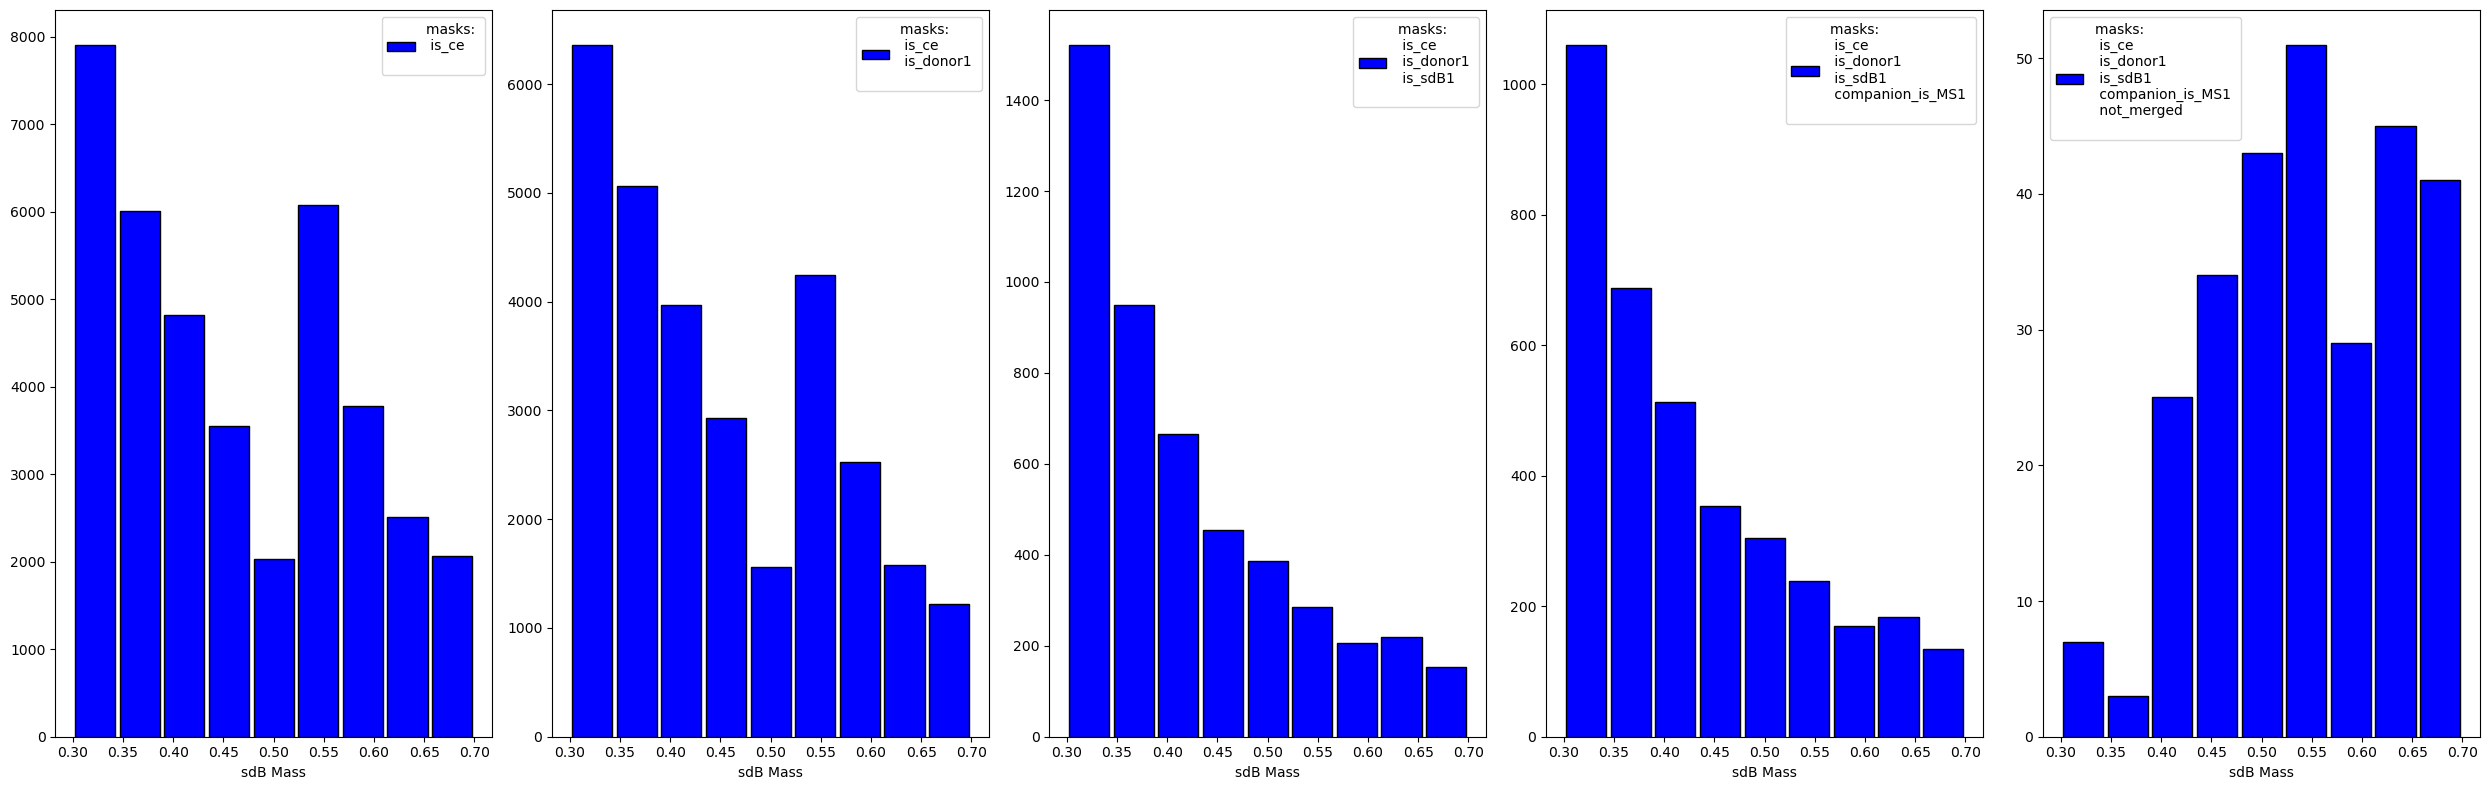

In [63]:
maskPlotter(1, CE_channel_1, CE1)

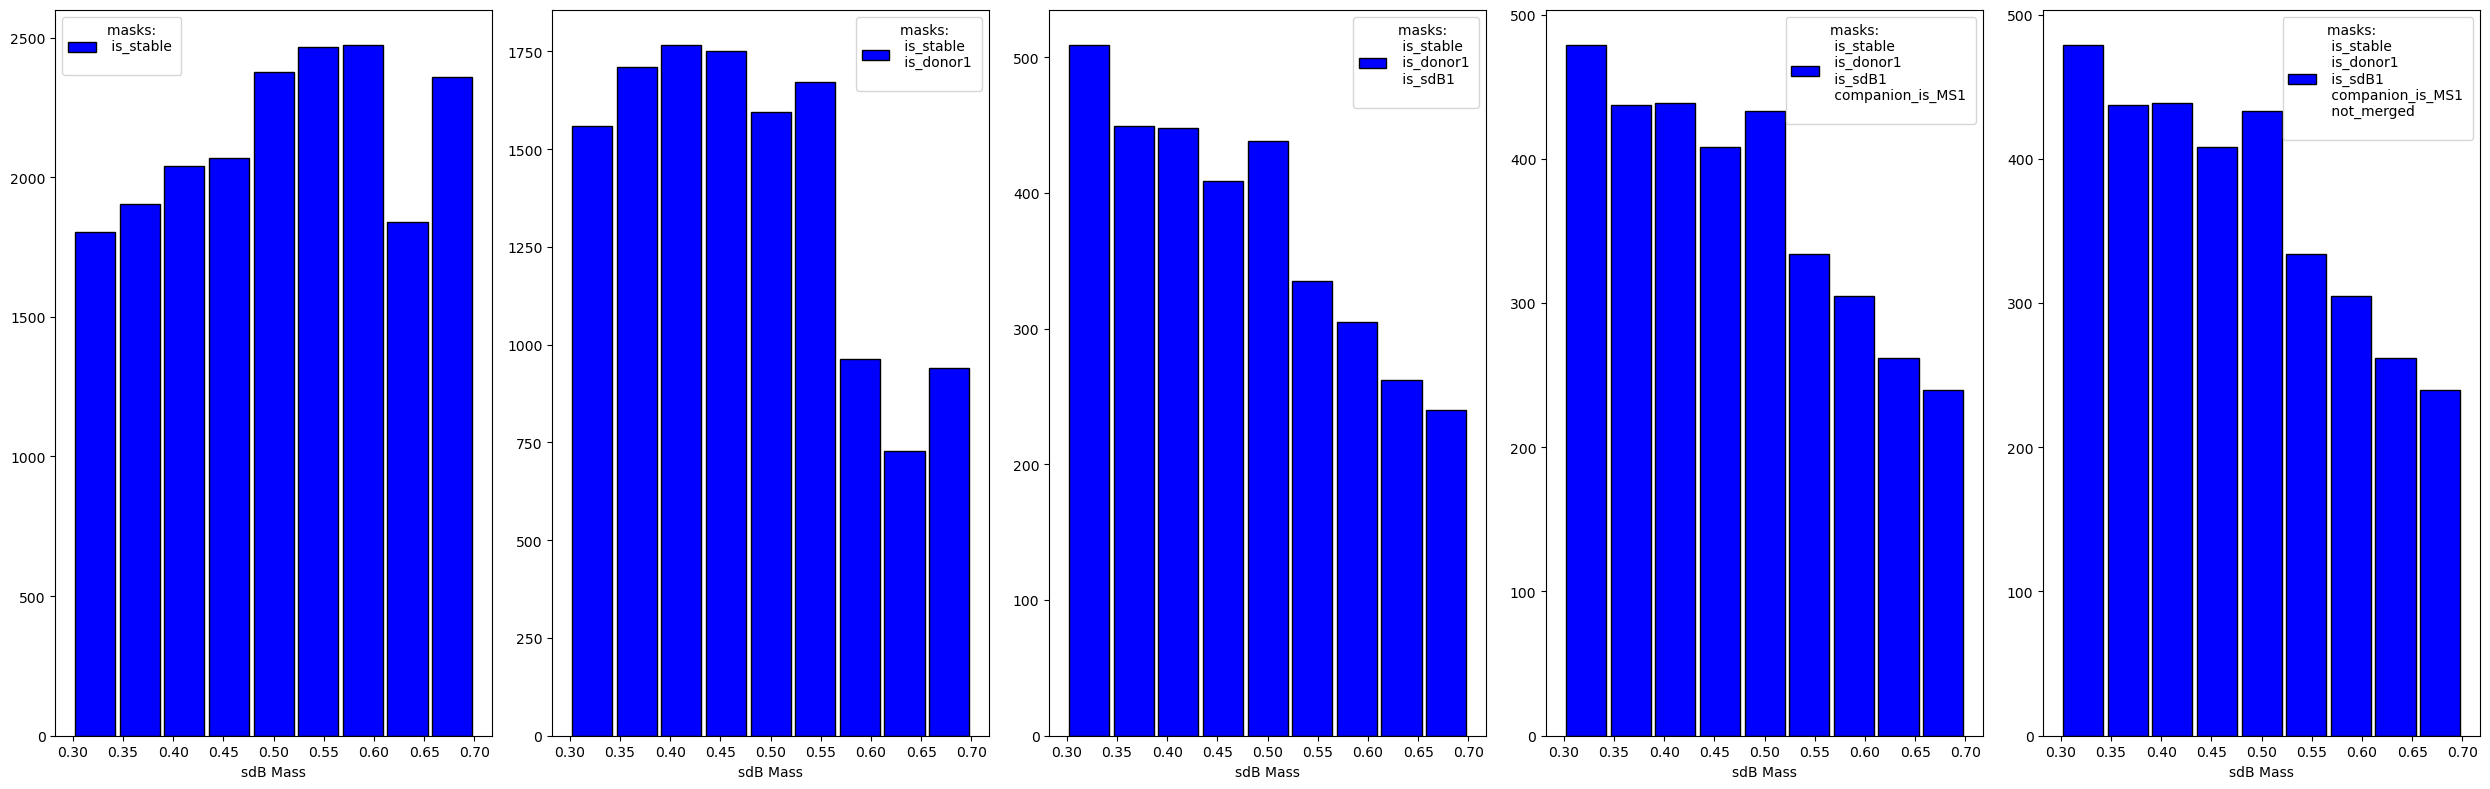

In [64]:
maskPlotter(1, STABLE_channel_1, STABLE1)

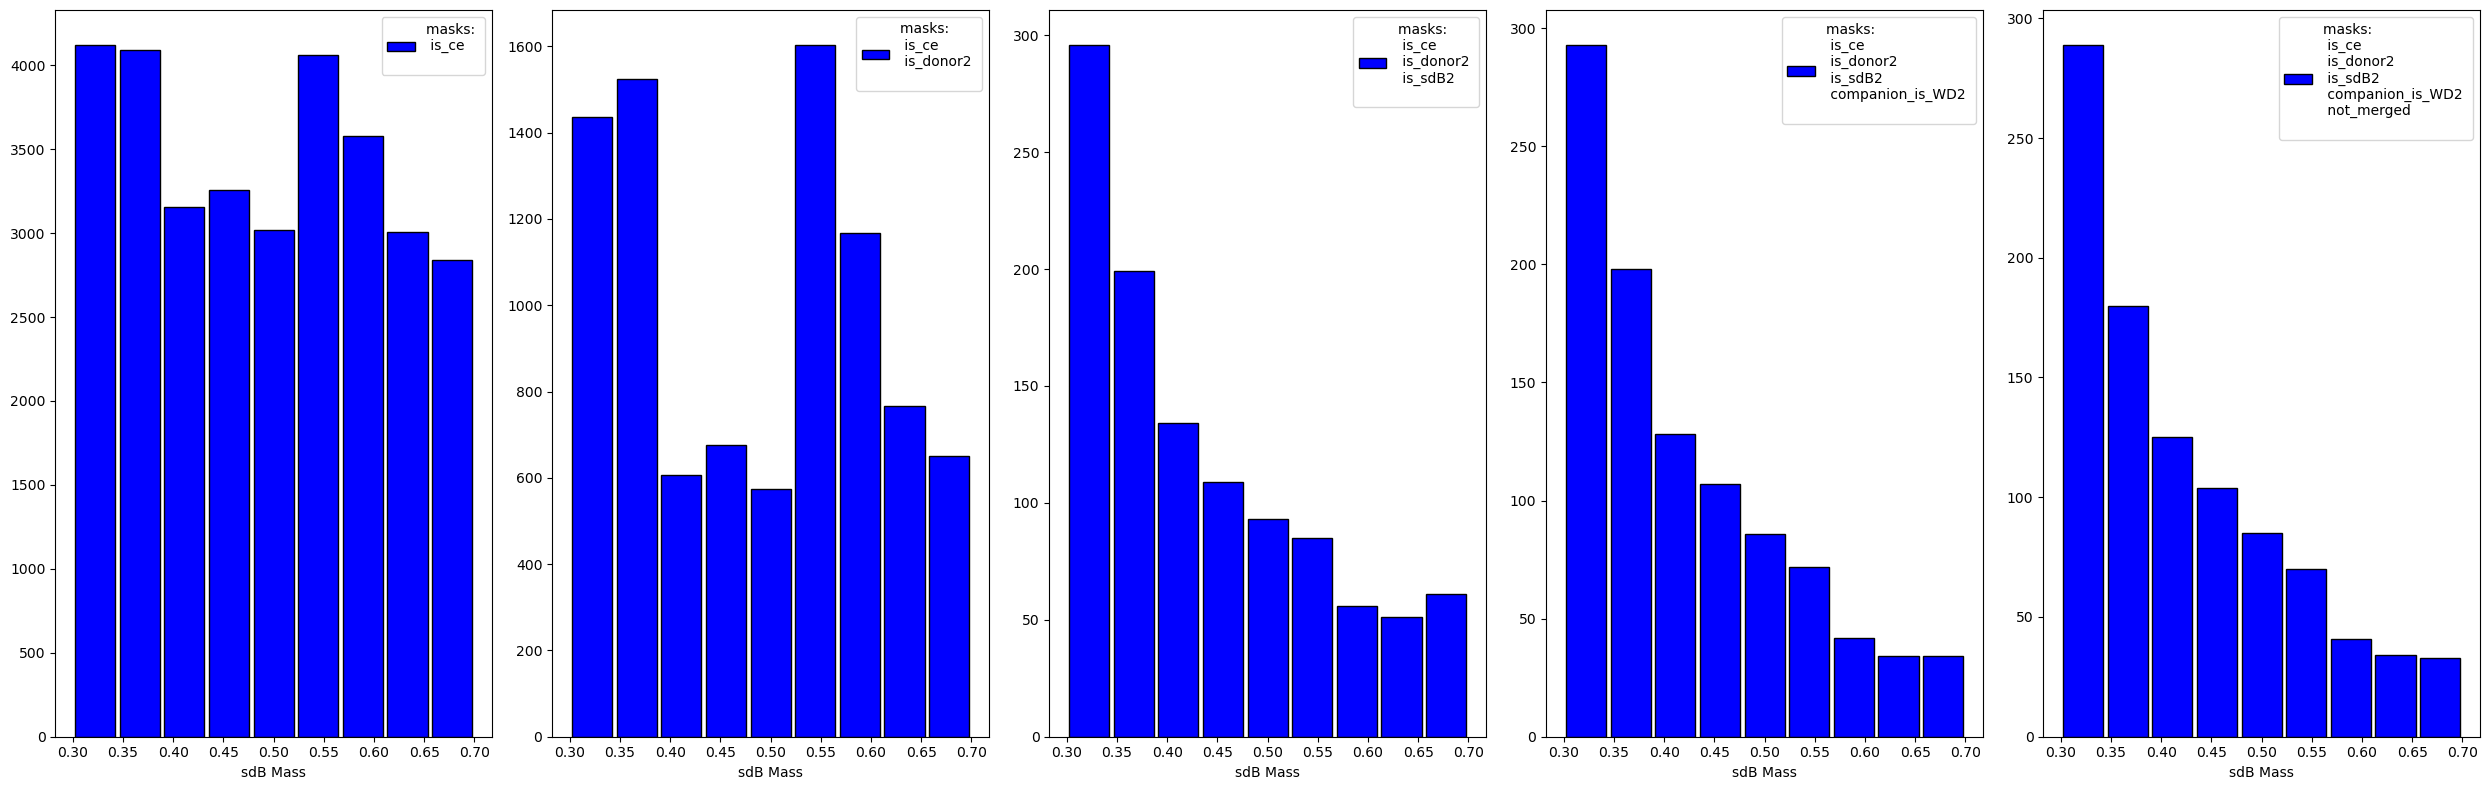

In [65]:
maskPlotter(2, CE_channel_2, CE2)

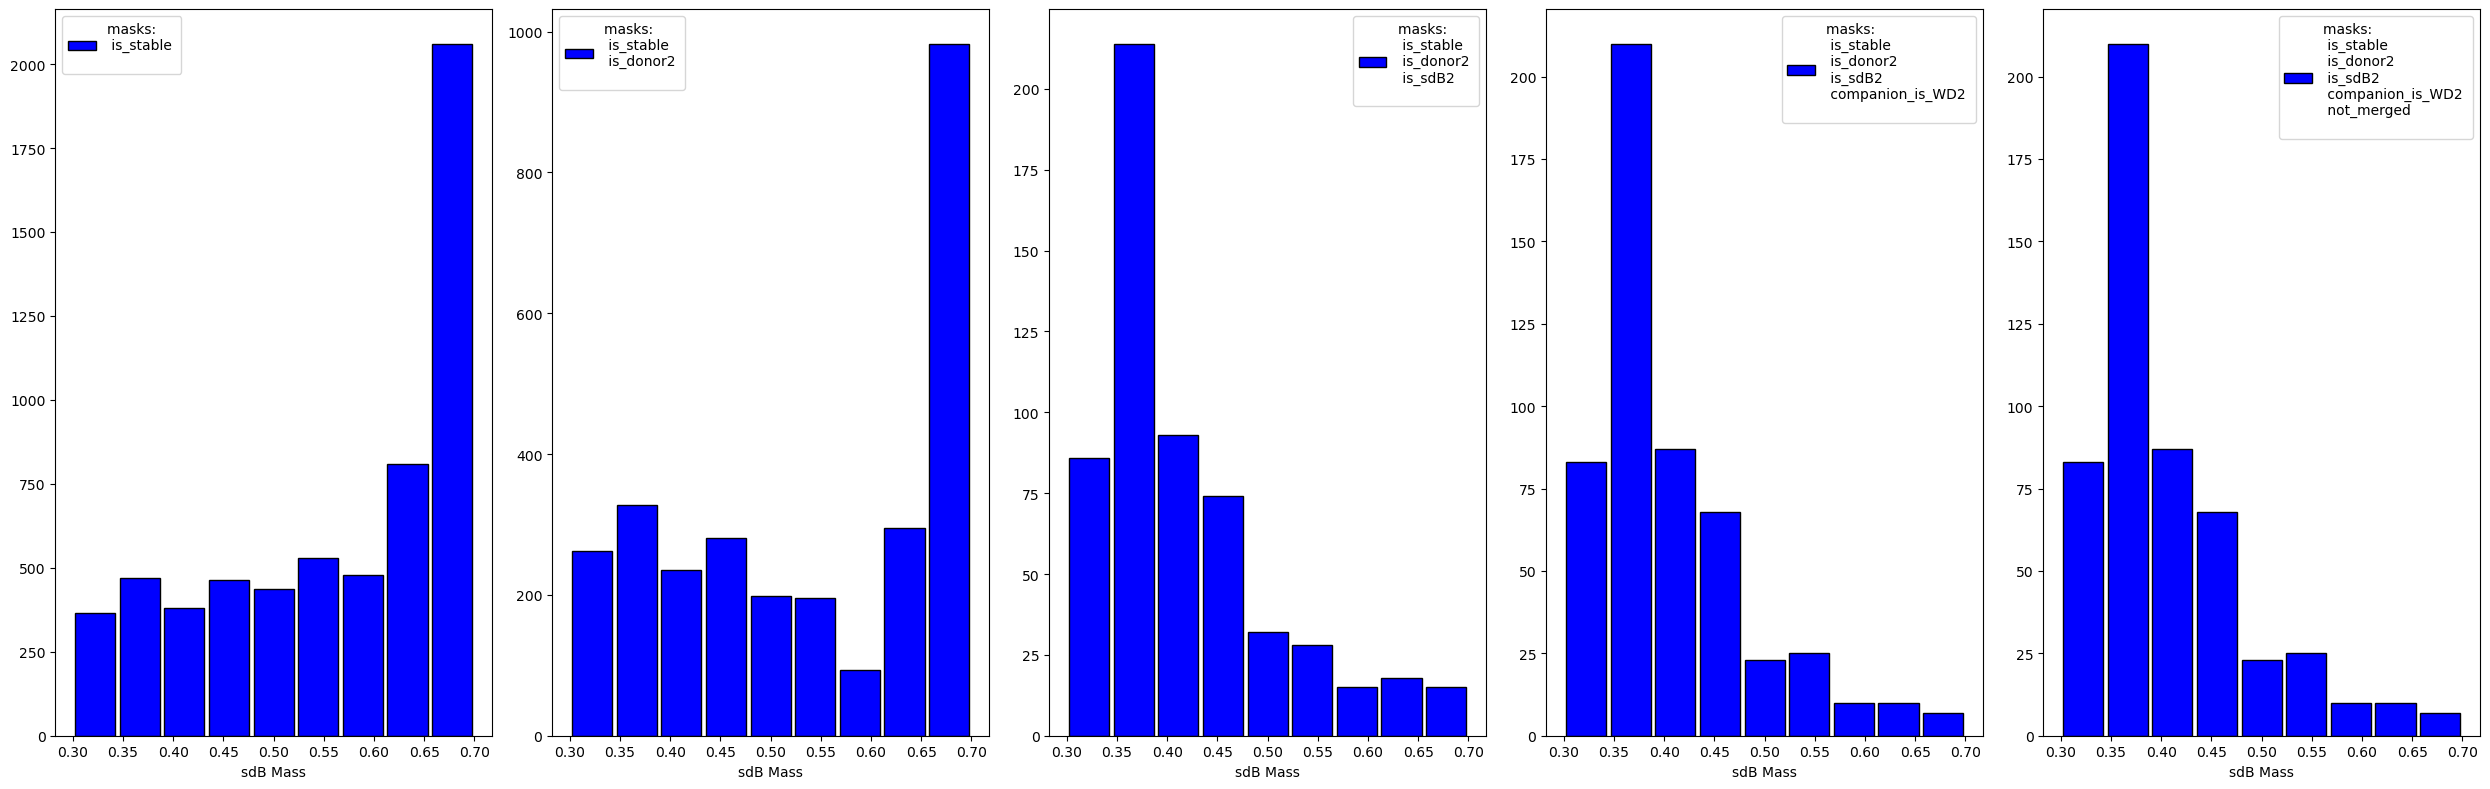

In [66]:
maskPlotter(2, STABLE_channel_2, STABLE2)

In [67]:
ce1 = combine_masks(CE_channel_1)
ce2 = combine_masks(CE_channel_2)
stable1 = combine_masks(STABLE_channel_1)
stable2 = combine_masks(STABLE_channel_2)
masses = [RLOF['Mass(1)'][ce1], RLOF['Mass(2)'][ce2], RLOF['Mass(1)'][stable1], RLOF['Mass(2)'][stable2]]
masses1 = [RLOF['Mass(1)'][ce1], RLOF['Mass(1)'][stable1]]
masses2 = [RLOF['Mass(2)'][ce2], RLOF['Mass(2)'][stable2]]

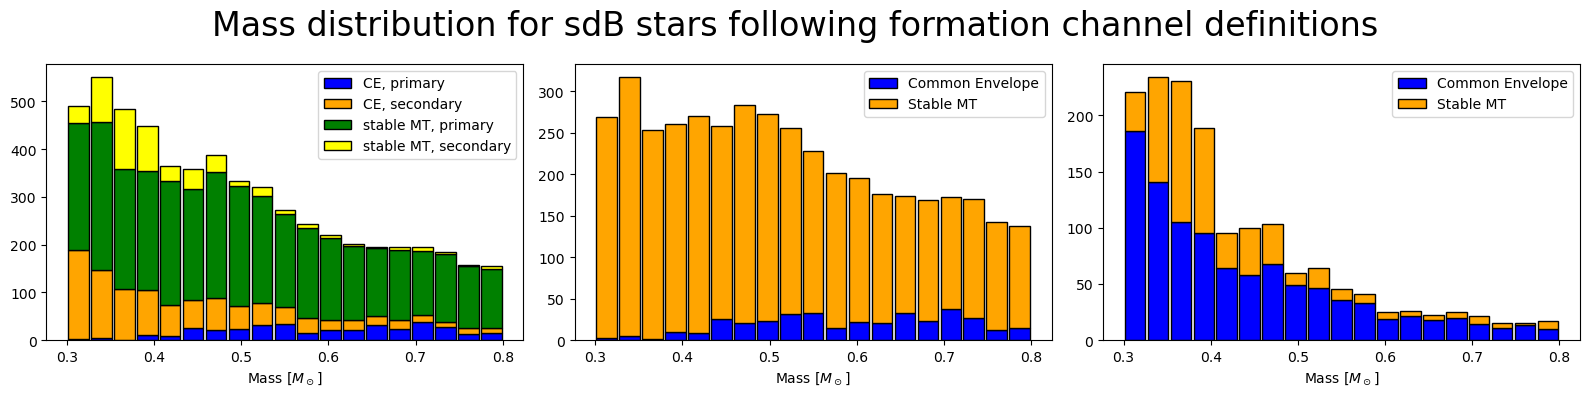

In [68]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

ax=axes[0]
ax.hist(masses, bins=mass_bins,stacked=True, color=['blue', 'orange', 'green', 'yellow'], \
        label=['CE, primary', 'CE, secondary', 'stable MT, primary', 'stable MT, secondary'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_xlabel(r'Mass [$M_\odot$]')

ax=axes[1]
ax.hist(masses1, bins=mass_bins,stacked=True, color=['blue', 'orange'], label=['Common Envelope', 'Stable MT'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_xlabel(r'Mass [$M_\odot$]')

ax=axes[2]
ax.hist(masses2, bins=mass_bins,stacked=True, color=['blue', 'orange'], label=['Common Envelope', 'Stable MT'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_xlabel(r'Mass [$M_\odot$]')

plt.suptitle('Mass distribution for sdB stars following formation channel definitions', fontsize=24)

plt.tight_layout()
plt.show()

## Pre-interaction masses

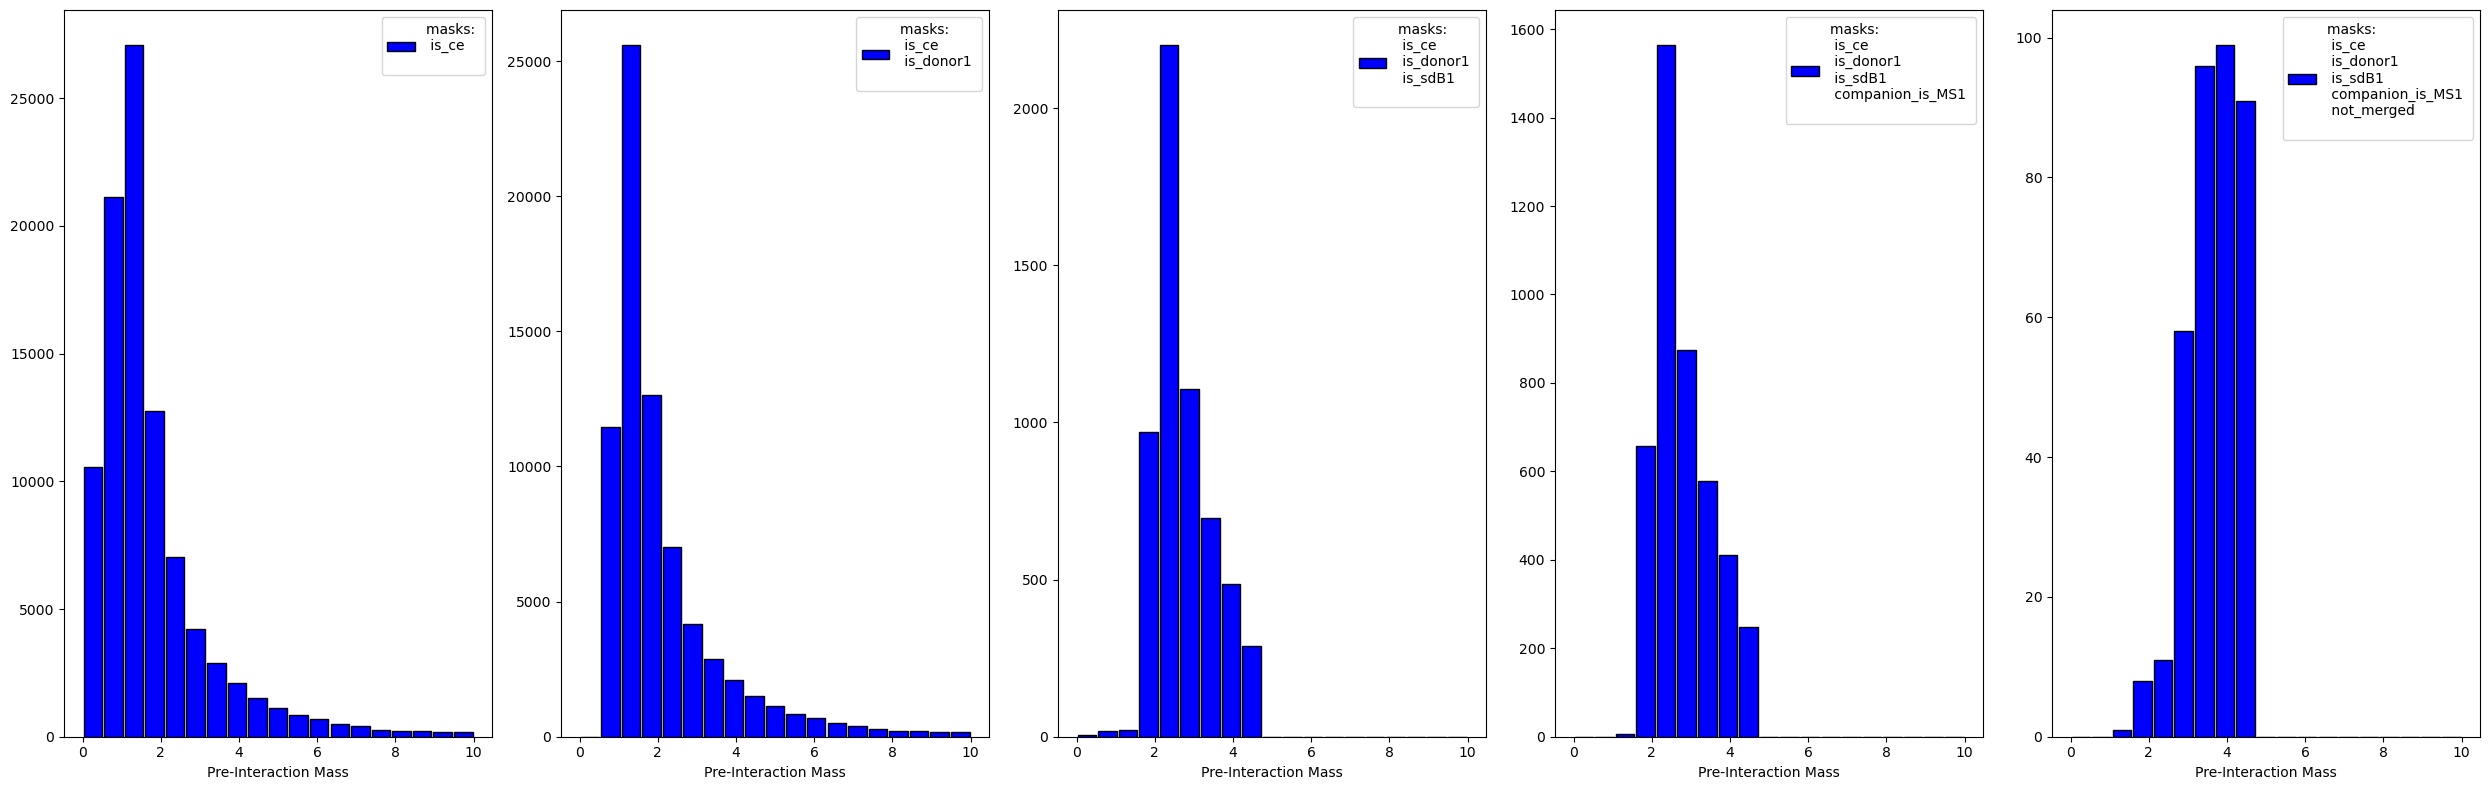

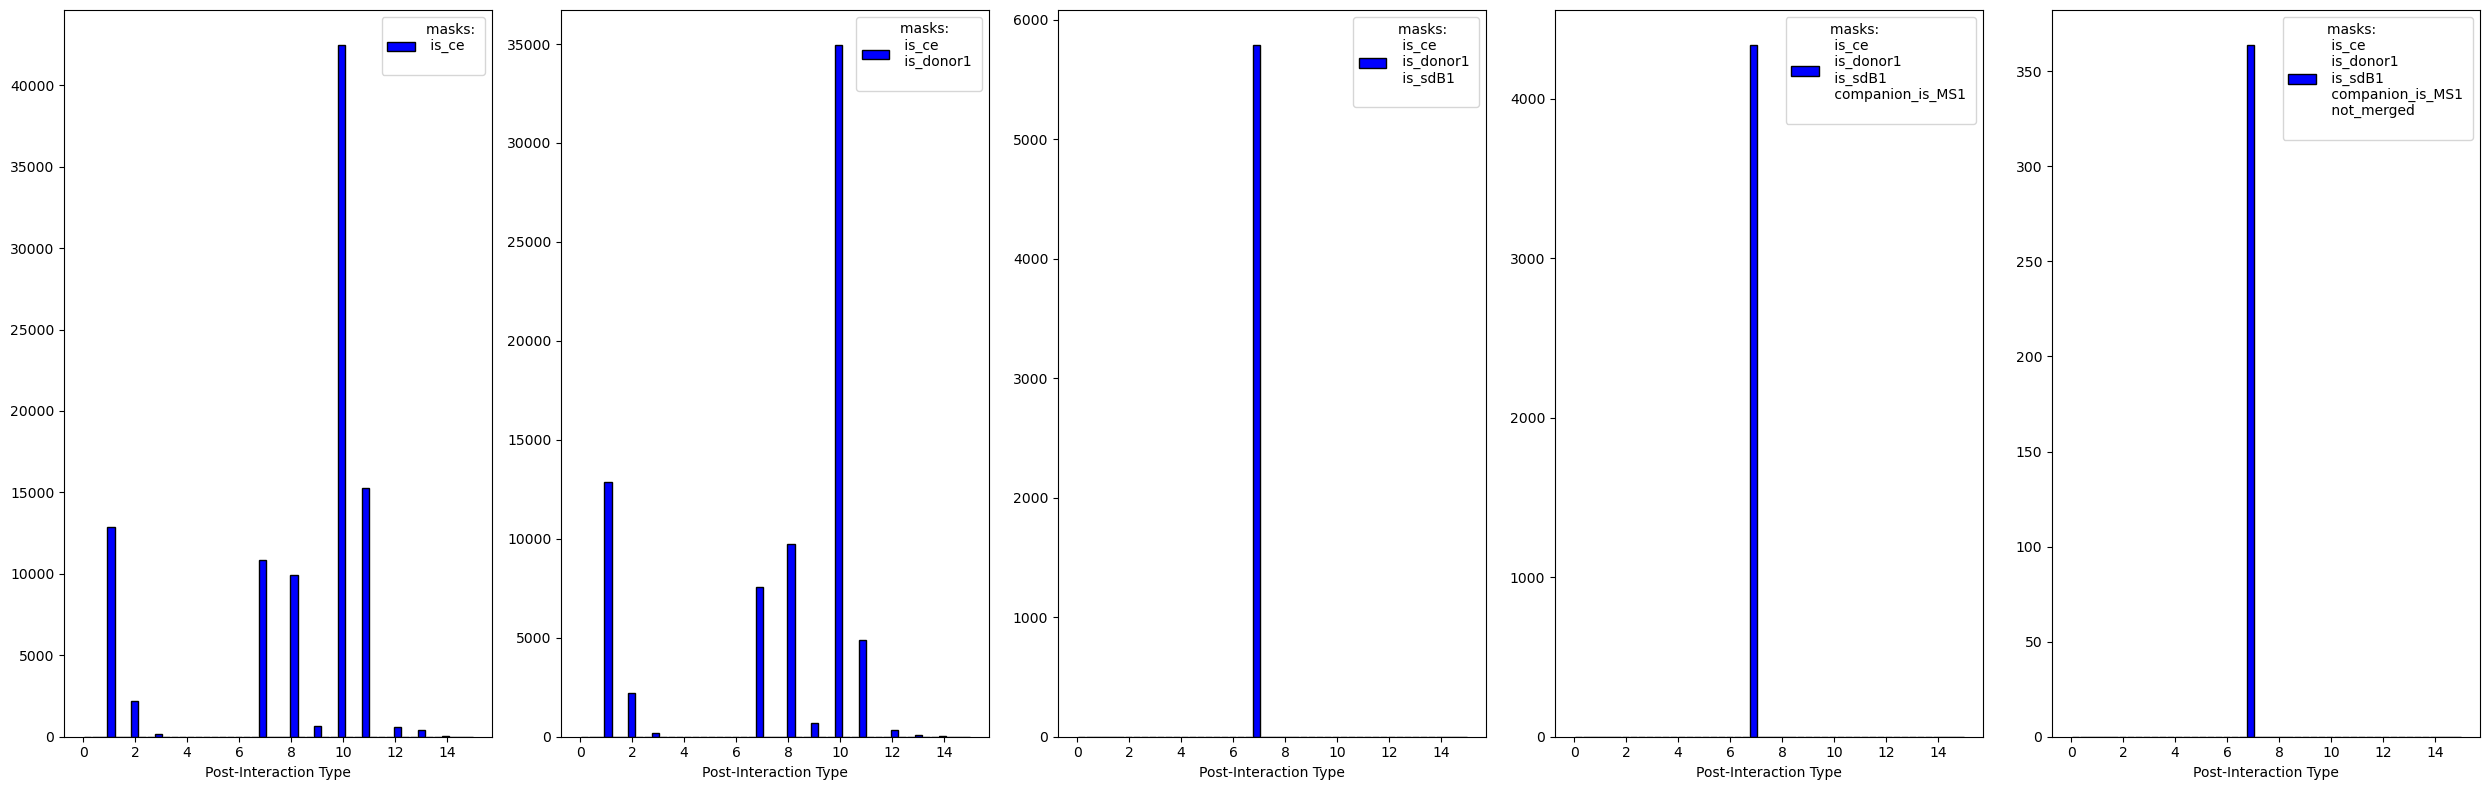

In [16]:
maskPlotter2(1, CE_channel_1, CE1)
maskPlotter3(1, CE_channel_1, CE1)

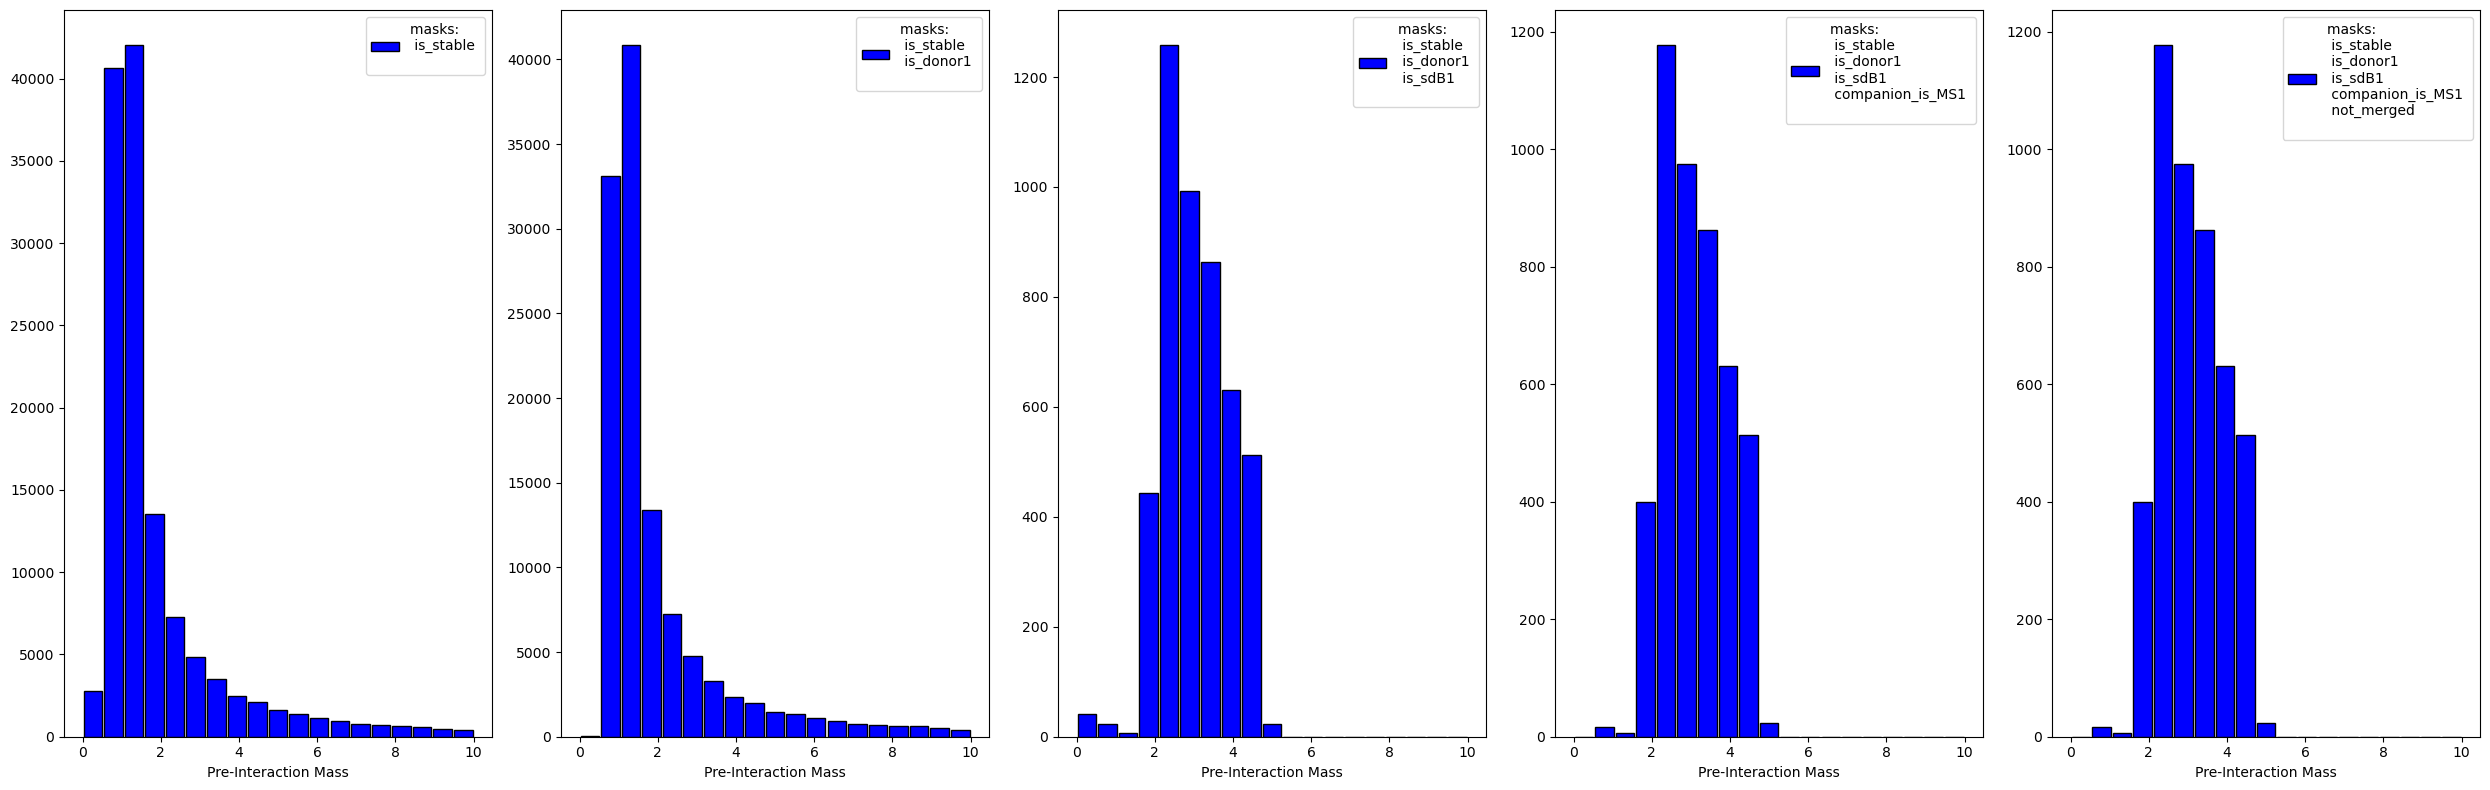

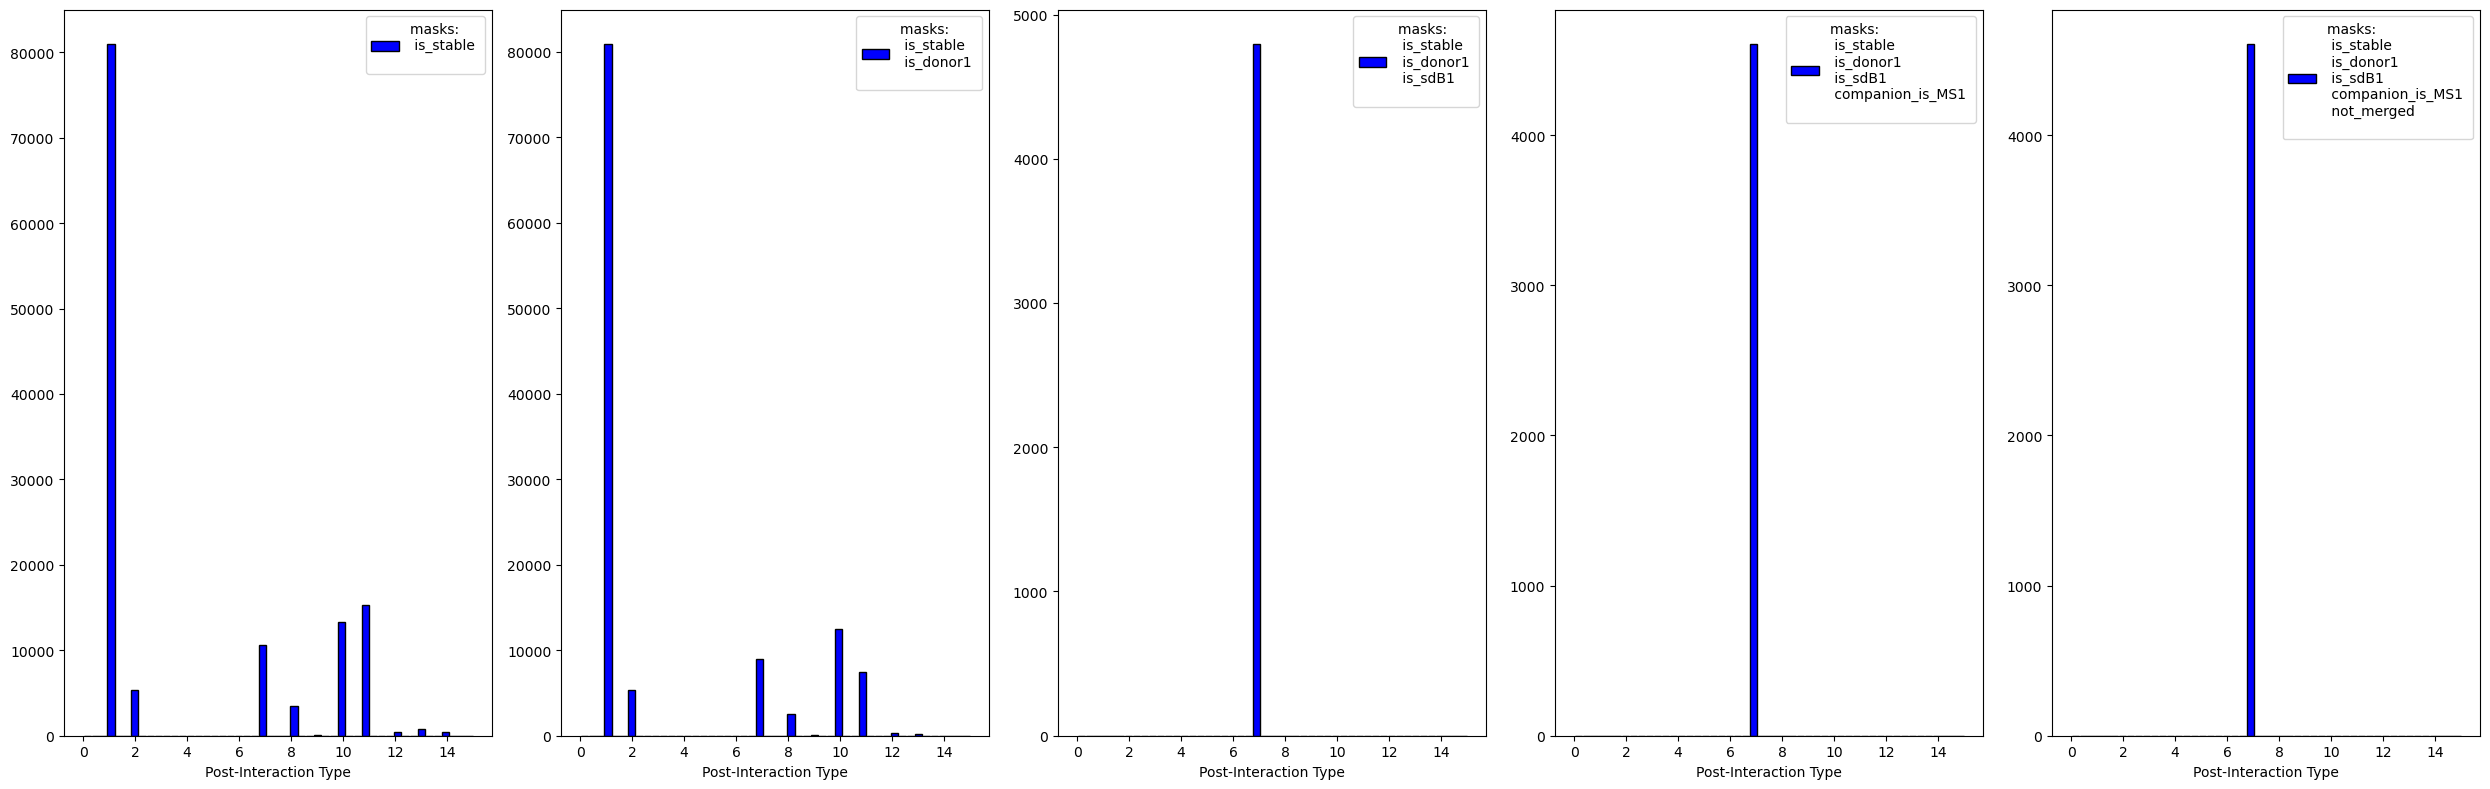

In [17]:
maskPlotter2(1, STABLE_channel_1, STABLE1)
maskPlotter3(1, STABLE_channel_1, STABLE1)

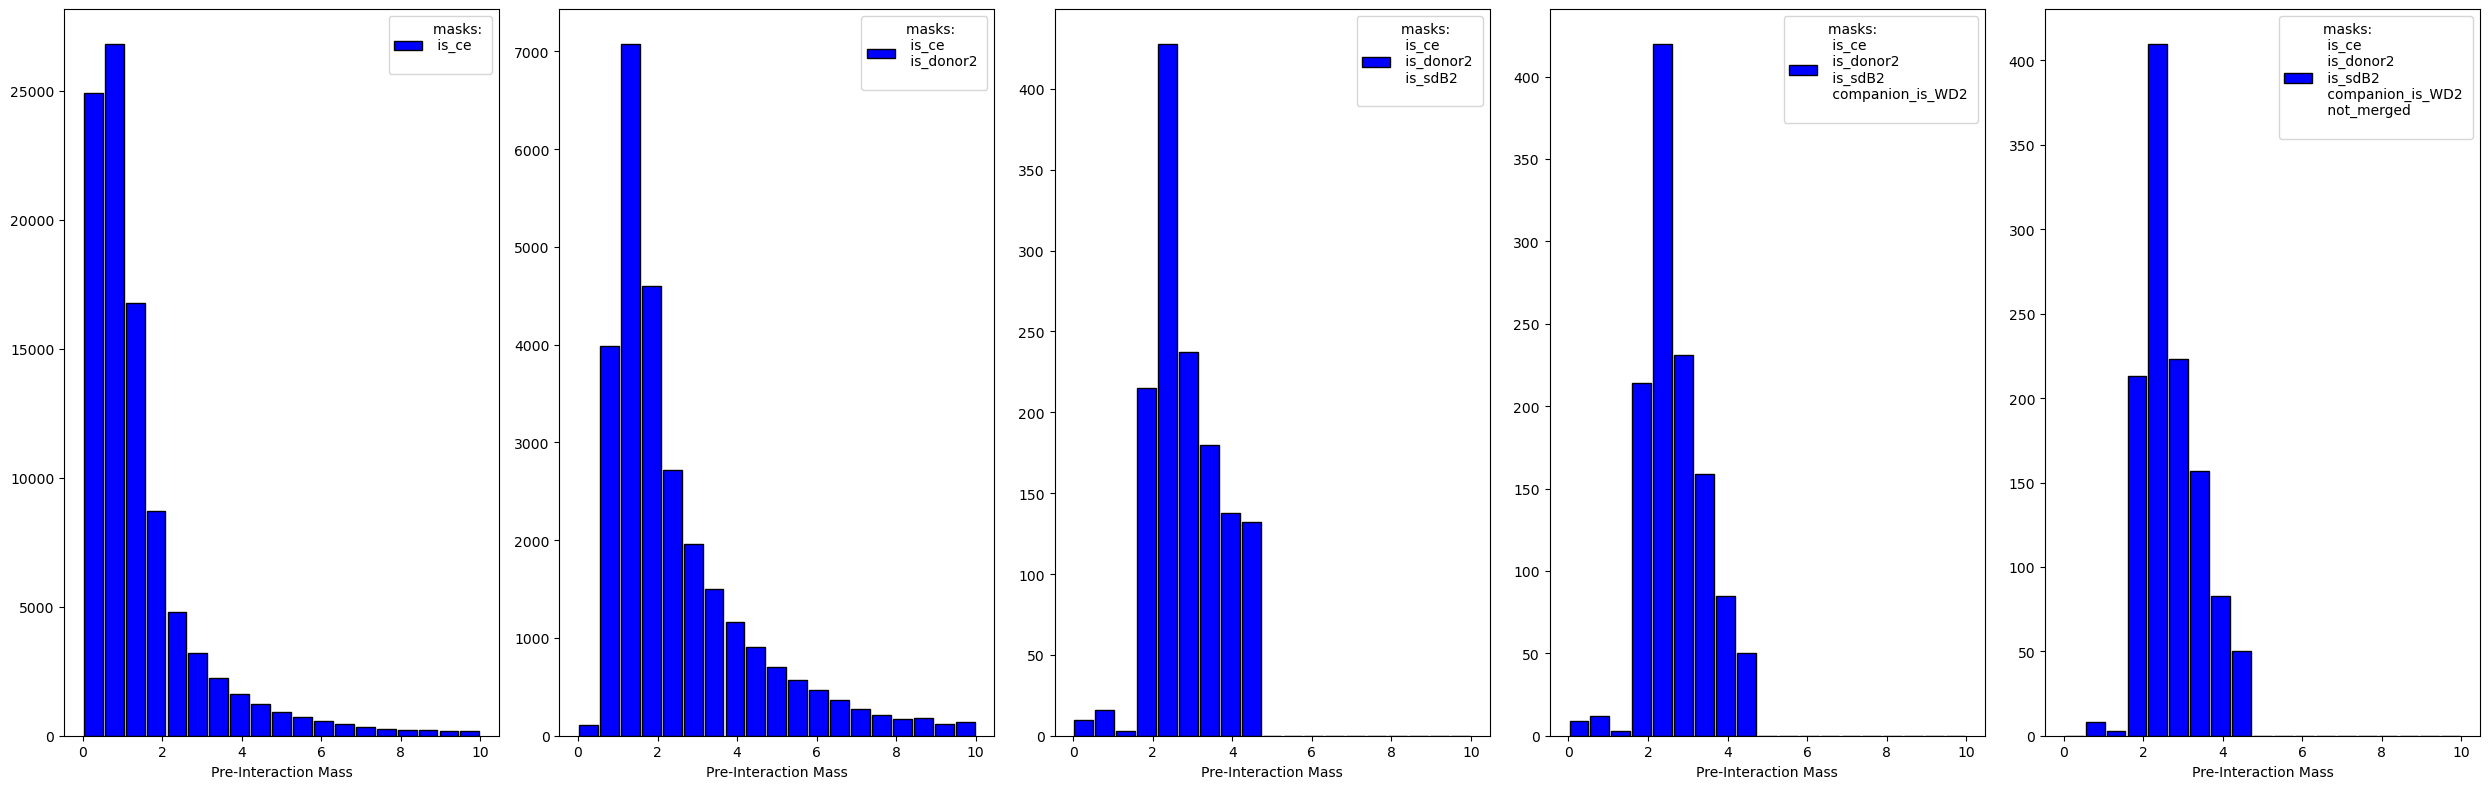

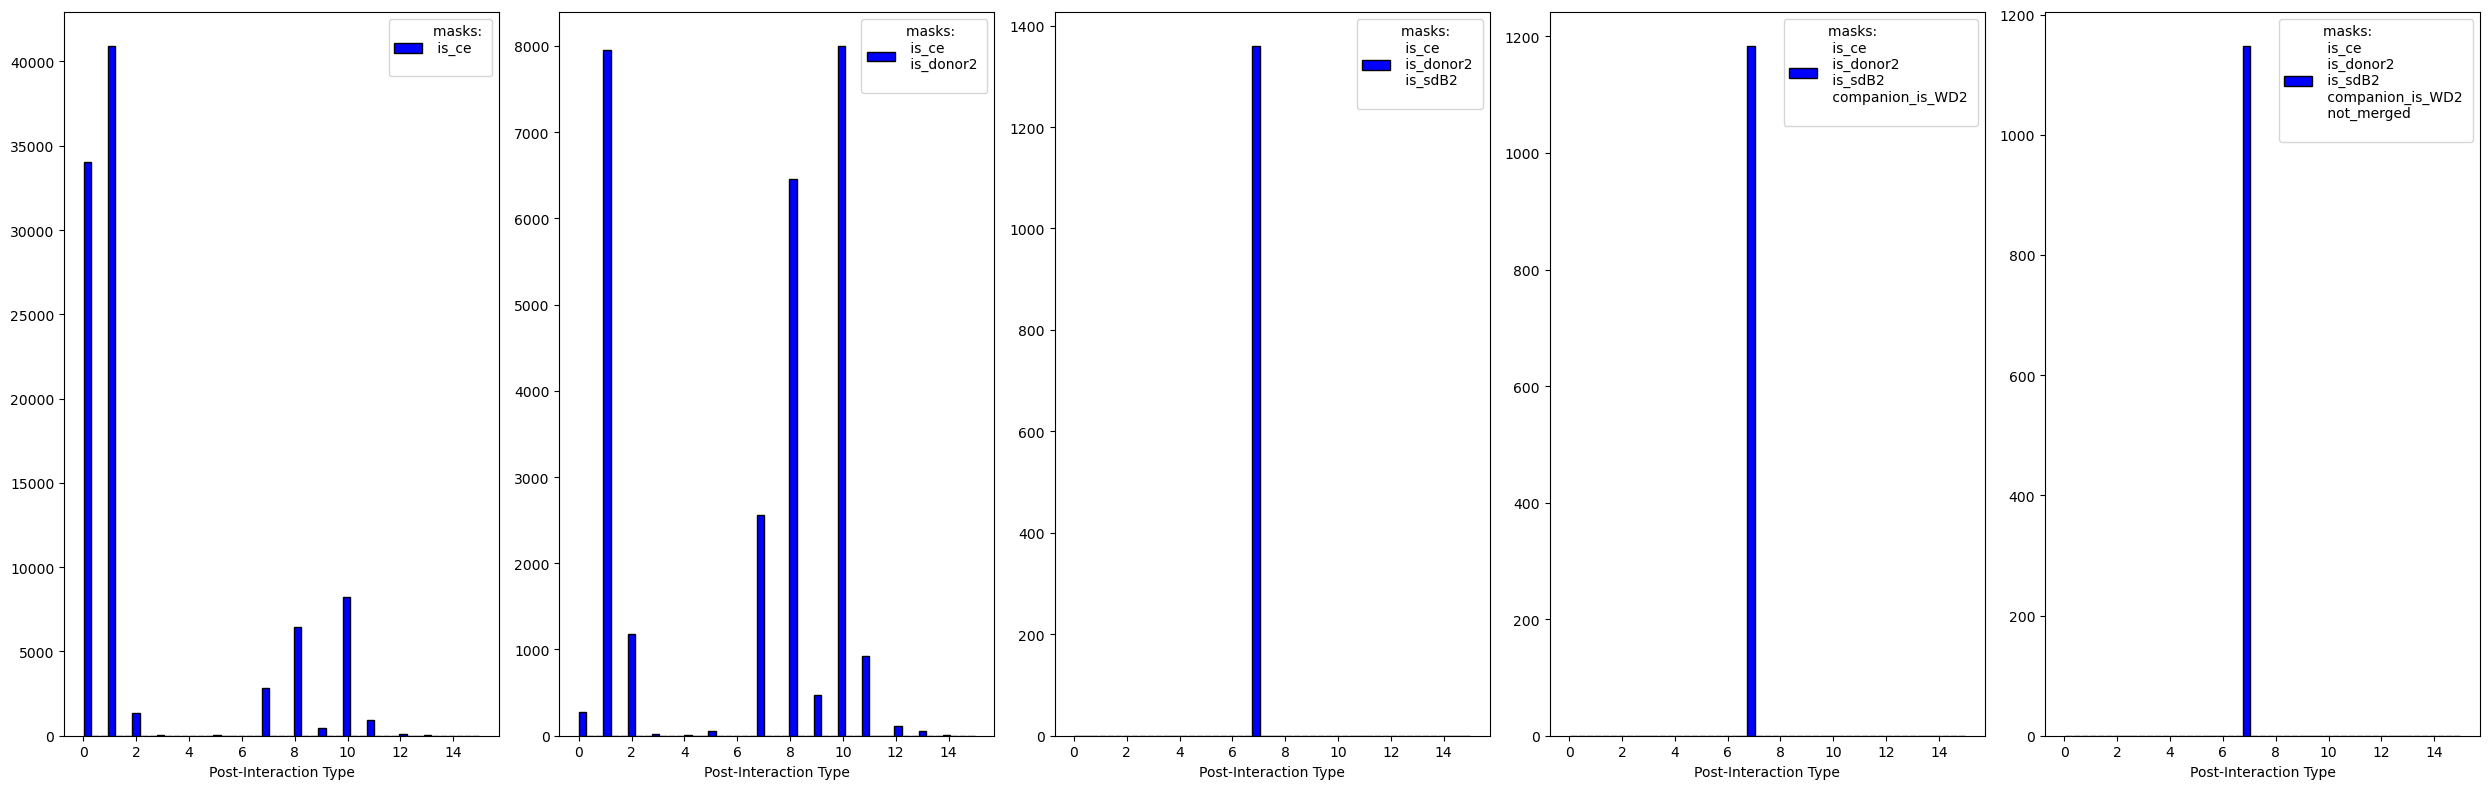

In [18]:
maskPlotter2(2, CE_channel_2, CE2)
maskPlotter3(2, CE_channel_2, CE2)

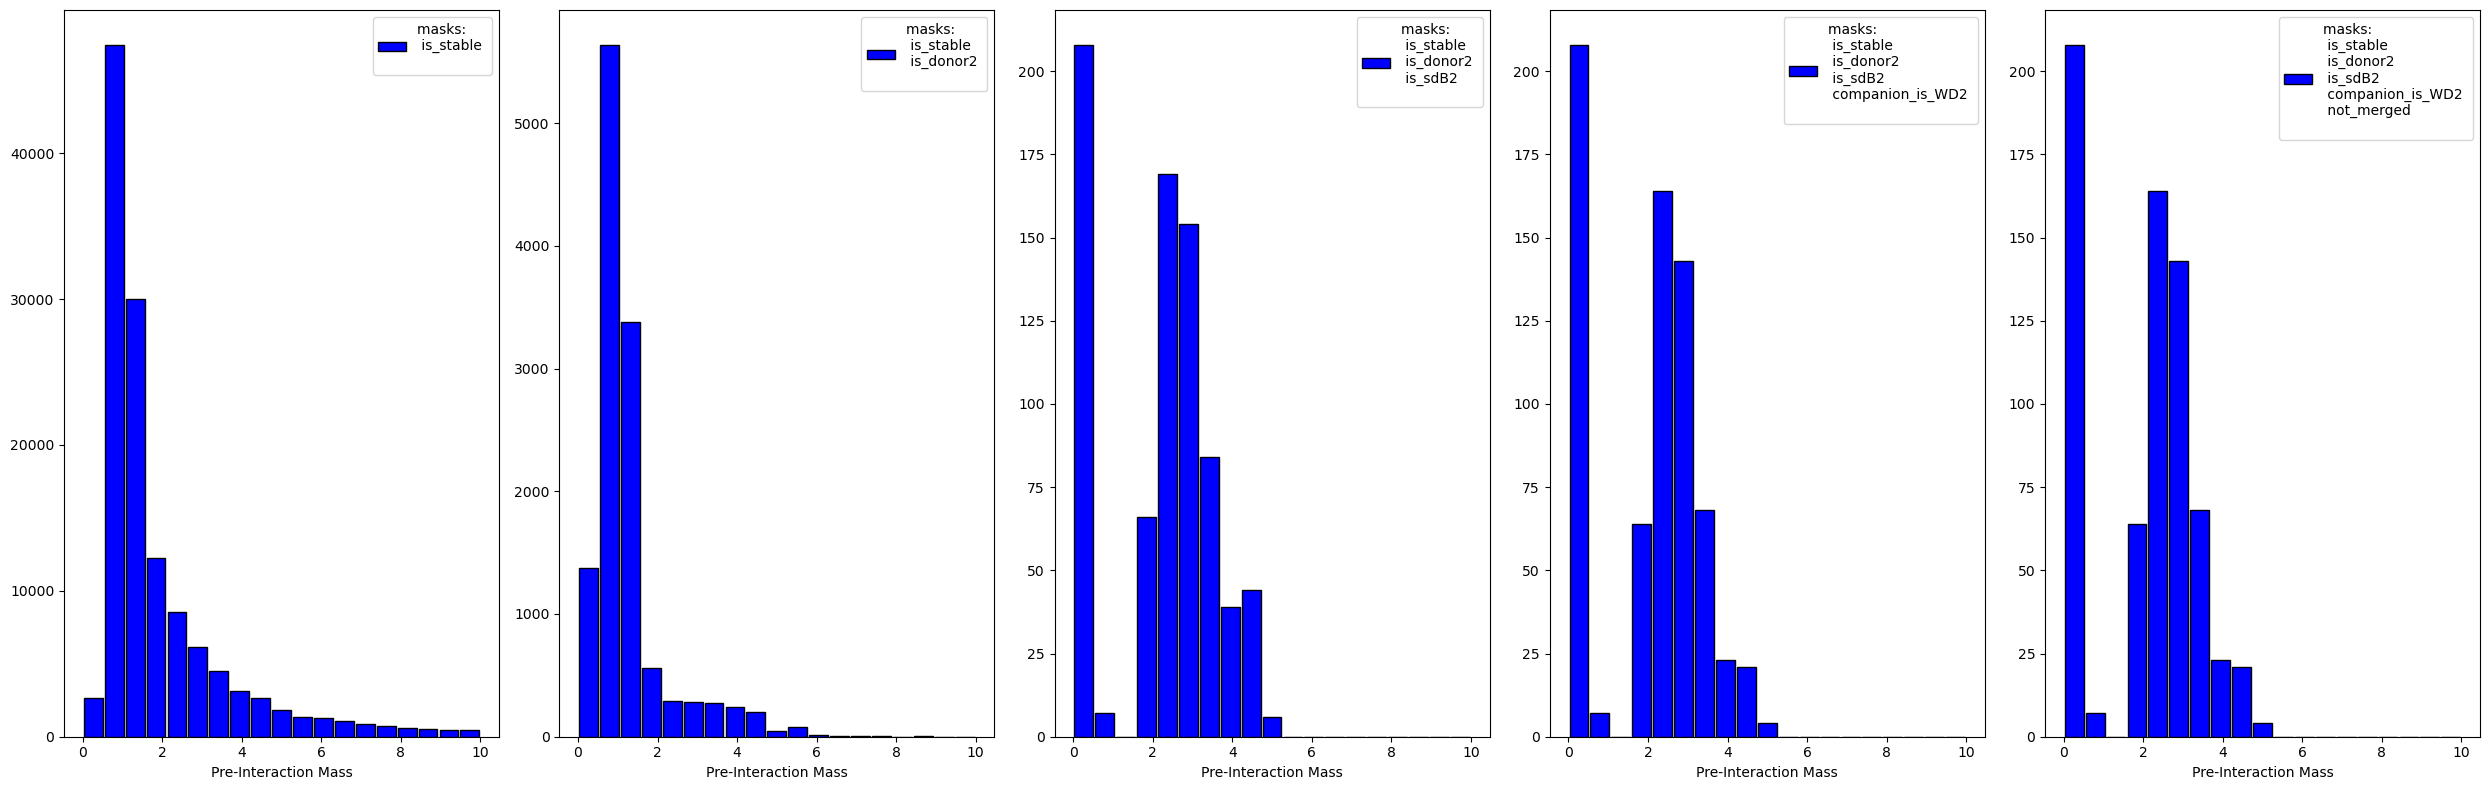

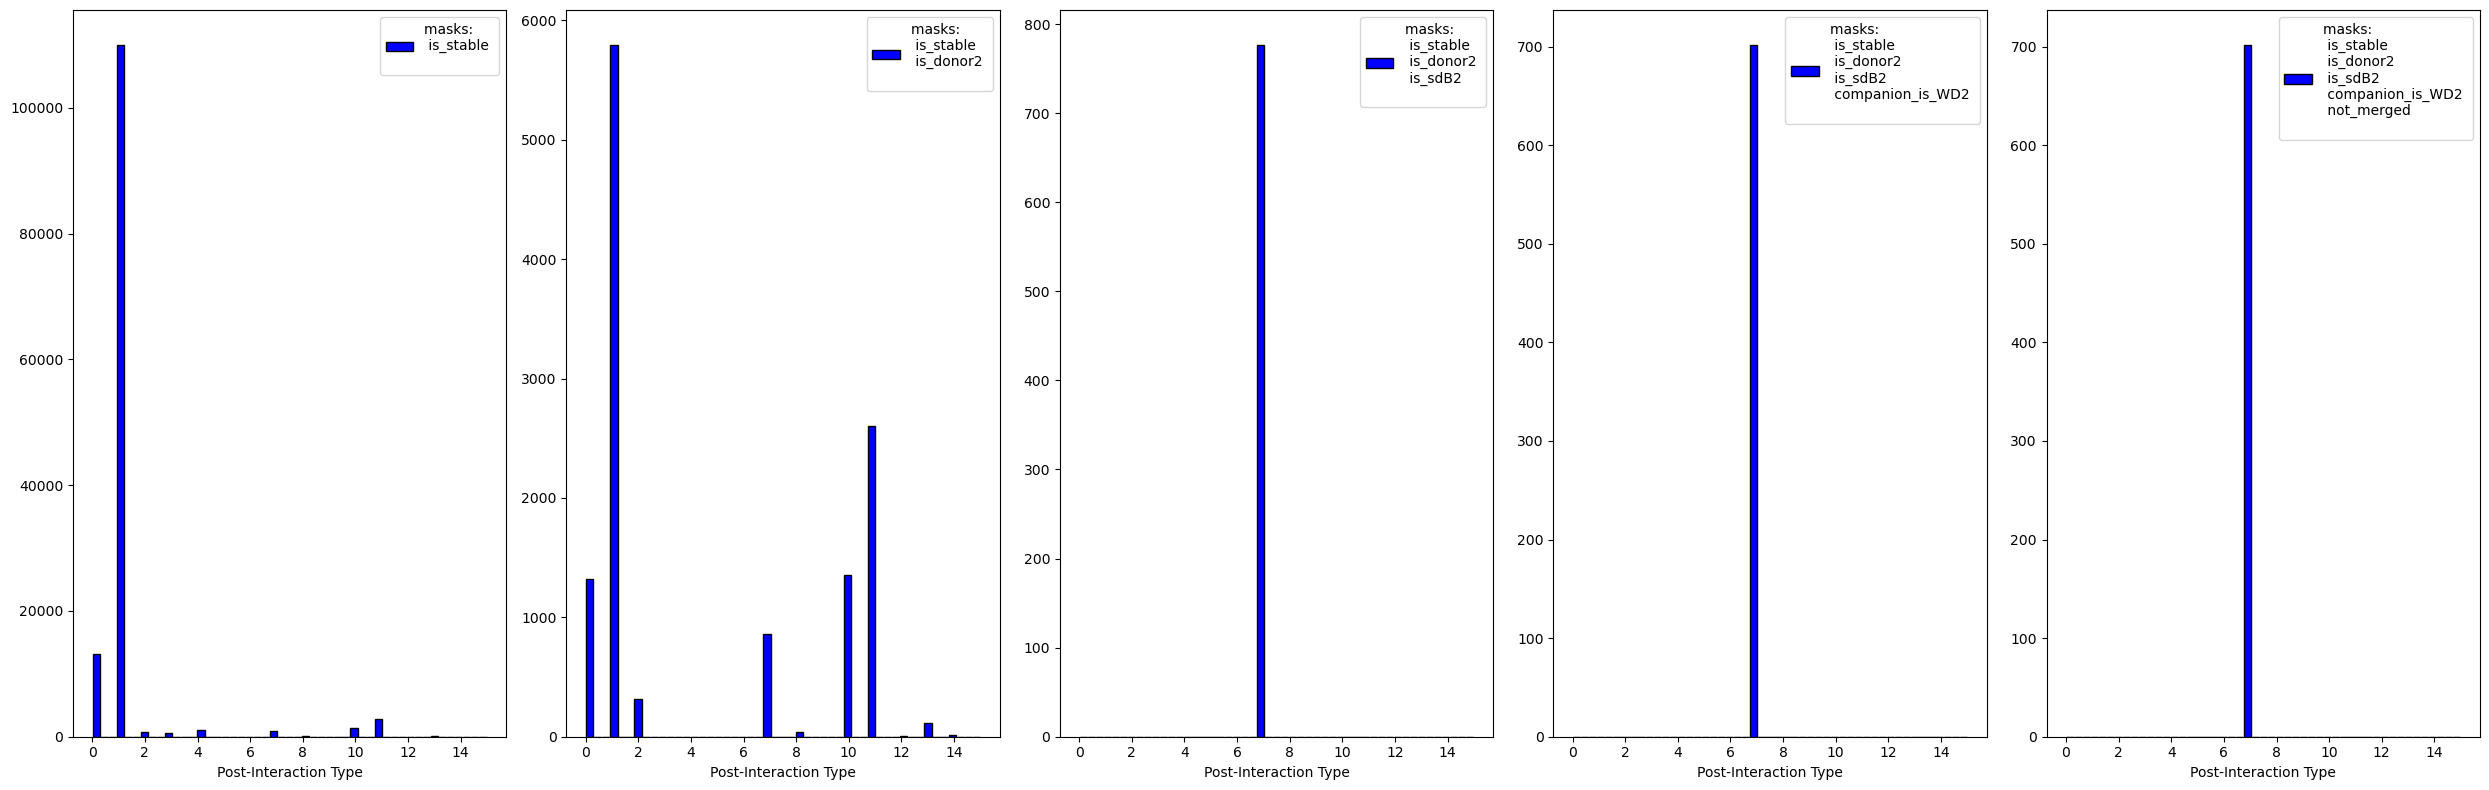

In [19]:
maskPlotter2(2, STABLE_channel_2, STABLE2)
maskPlotter3(2, STABLE_channel_2, STABLE2)

## General sdB mask and observational criterium

### General sdB mask 
We define a more general sdB mask by neglecting the formation channels. The only masks applied are:
- The star became an HeMS star
- of low mass
- with a small envelope
- that did not merge immediately

In [20]:
HeStar = [7]
became_HeMS1 = np.in1d(RLOF['Stellar_Type(1)<MT'][()], HeStar, invert=True) & np.in1d(RLOF['Stellar_Type(1)>MT'][()], HeStar)
became_HeMS2 = np.in1d(RLOF['Stellar_Type(2)<MT'][()], HeStar, invert=True) & np.in1d(RLOF['Stellar_Type(2)>MT'][()], HeStar)

of_low_mass1 = (RLOF['Mass(1)'][()] <= 0.8)
of_low_mass2 = (RLOF['Mass(2)'][()] <= 0.8)

with_small_envelope1 = (RLOF['Mass(1)'][()]-RLOF['Mass_He_Core(1)'][()] <= 0.1)
with_small_envelope2 = (RLOF['Mass(2)'][()]-RLOF['Mass_He_Core(2)'][()] <= 0.1)

did_not_merge = (RLOF['Merger'][()]==0)

In [21]:
sdBs1 = became_HeMS1 & of_low_mass1 & with_small_envelope1 & did_not_merge
sdBs2 = became_HeMS2 & of_low_mass2 & with_small_envelope2 & did_not_merge

In [22]:
general_masses1 = RLOF['Mass(1)'][sdBs1]
general_masses2 = RLOF['Mass(2)'][sdBs2]

general_masses = [general_masses1, general_masses2]

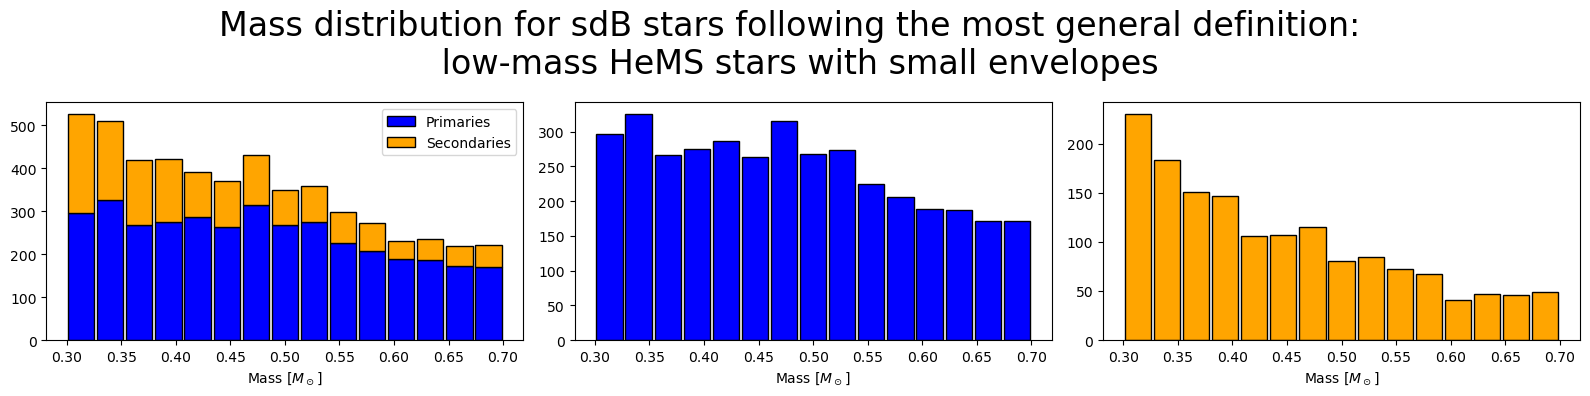

In [23]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

ax=axes[0]
ax.hist(general_masses, bins=mass_bins, stacked=True, color=['blue', 'orange'], label=['Primaries', 'Secondaries'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_xlabel(r'Mass [$M_\odot$]')

ax=axes[1]
ax.hist(general_masses[0], bins=mass_bins, color='blue', label='Primaries', edgecolor='black', rwidth=0.9)
ax.set_xlabel(r'Mass [$M_\odot$]')

ax=axes[2]
ax.hist(general_masses[1], bins=mass_bins, color='orange', label='Secondaries', edgecolor='black', rwidth=0.9)
ax.set_xlabel(r'Mass [$M_\odot$]')

plt.suptitle('Mass distribution for sdB stars following the most general definition: \n low-mass HeMS stars with small envelopes', fontsize=24)

plt.tight_layout()
plt.show()

### Kiel-diagram: observational mask

Following the observational selection criterium defined in Rodriguez-Segovia et al., we define an additional selection criterium based on the size and effective temperature of the stars. The candidate sdBs should be within the region defined by:
$$ \log g = 6 \log T - 20.4 $$
$$ \log g = 6 \log T - 22.4 $$
$$ \log g = -3.4 \log T + 21.8 $$
$$ \log g = -3.4 \log T + 19.3 $$
with $T$ in Kelvins and $g$ in $cm$ $s^{-2}$.

In [24]:
def getLogg(systems, primary_or_secondary):
    if primary_or_secondary==1:
        mass = RLOF['Mass(1)>MT'][systems]/g
        radius = RLOF['Radius(1)>MT'][systems]/cm
        logg = np.log10( G_cgs * ( mass / radius**2) )
               
    if primary_or_secondary==2:
        mass = RLOF['Mass(2)>MT'][systems]/g
        radius = RLOF['Radius(2)>MT'][systems]/cm
        logg = np.log10( G_cgs * ( mass / radius**2) )
        
    return logg   

In [25]:
def plotKielCriterium(color):
    T1 = np.linspace(39.7/9.4, 41.7/9.4, 1000)
    T2 = np.linspace(41.7/9.4, 44.2/9.4, 1000)
    T3 = np.linspace(42.2/9.4, 44.2/9.4, 1000)
    T4 = np.linspace(39.7/9.4, 42.2/9.4, 1000)
    ax.plot(T1, -3.4*T1 + 19.3, color=color)
    ax.plot(T2, 6*T2 - 22.4, color=color)
    ax.plot(T3, -3.4*T3 + 21.8, color=color)
    ax.plot(T4, 6*T4 - 20.4, color=color, label='Observational Selection Criterium')
    ax.invert_xaxis()
    ax.invert_yaxis()

def scatterKiel(systems, primary_or_secondary):
    if (primary_or_secondary==1):
        marker='d'
        logT = np.log10(RLOF['Teff(1)'][systems])
        logg = getLogg(systems, primary_or_secondary)
        mass = RLOF['Mass(1)'][systems]
        scatter = ax.scatter(logT, logg, c=mass, cmap='viridis', s=4, marker=marker)
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('sdB Mass Primary')
        
    if (primary_or_secondary==2):
        marker='s'
        logT = np.log10(RLOF['Teff(2)'][systems])
        logg = getLogg(systems, primary_or_secondary)
        mass = RLOF['Mass(2)'][systems]
        scatter = ax.scatter(logT, logg, c=mass, cmap='viridis', s=4, marker=marker)
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('sdB Mass Secondary')
    

In [26]:
def checkKiel(logT, logg):
    
    checks = np.zeros_like(logT, dtype=bool)
    
    for i in range(len(logT)):
        if (39.7/9.4 <= logT[i] <= 41.7/9.4):
            check = (logg[i] > -3.4*logT[i] + 19.3) & (logg[i] < 6*logT[i] - 20.4)
            checks[i] = check
        if (41.7/9.4 <= logT[i] <= 42.2/9.4):
            check = (logg[i] > 6*logT[i] - 22.4) & (logg[i] < 6*logT[i] - 20.4)
            checks[i] = check
        if (42.2/9.4 <= logT[i] <= 44.2/9.4):
            check = (logg[i] > 6*logT[i] - 22.4) & (logg[i] < -3.4*logT[i] + 21.8)
            checks[i] = check
        
    return checks  

def applyKielSelection(systems, primary_or_secondary):
    if (primary_or_secondary==1):
        logT = np.log10(RLOF['Teff(1)'][systems])
        logg = getLogg(systems, primary_or_secondary)
        passed_check = checkKiel(logT, logg)
        return passed_check
    if (primary_or_secondary==2):
        logT = np.log10(RLOF['Teff(2)'][systems])
        logg = getLogg(systems, primary_or_secondary)
        passed_check = checkKiel(logT, logg)
        return passed_check

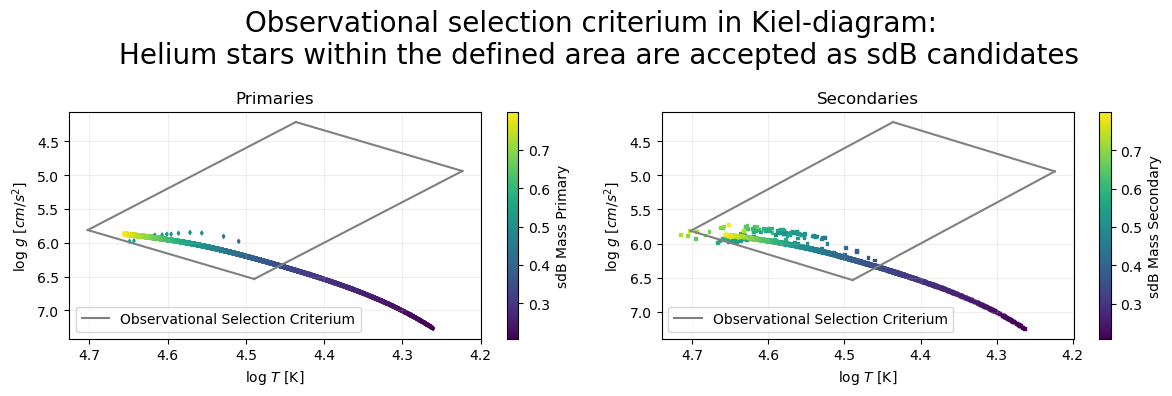

In [27]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

plt.suptitle('Observational selection criterium in Kiel-diagram: \n Helium stars within the defined area are accepted as sdB candidates', fontsize=20)

ax=axes[0]
plotKielCriterium('grey')
scatterKiel(sdBs1, 1)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel(r'log $T$ [K]')
ax.set_ylabel(r'log $g$ [$cm/s^2$]')
ax.set_title('Primaries')

ax=axes[1]
plotKielCriterium('grey')
scatterKiel(sdBs2, 2)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel(r'log $T$ [K]')
ax.set_ylabel(r'log $g$ [$cm/s^2$]')
ax.set_title('Secondaries')

plt.tight_layout()
plt.show()

In [28]:
kiel_check1 = applyKielSelection(sdBs1, 1)
kiel_check2 = applyKielSelection(sdBs2, 2)

In [29]:
masses = [RLOF['Mass(1)'][sdBs1][kiel_check1], RLOF['Mass(2)'][sdBs2][kiel_check2]]

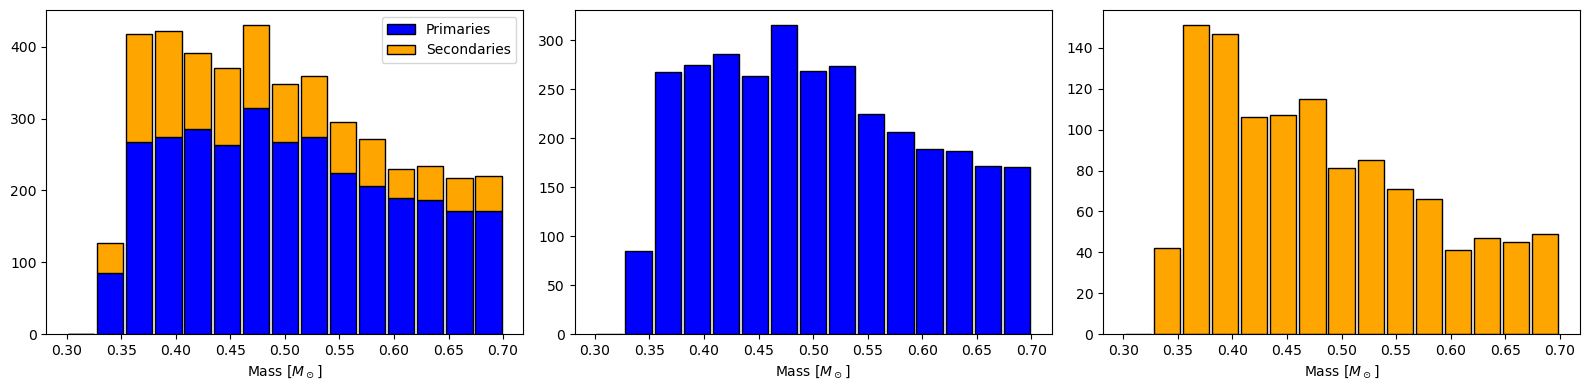

In [30]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

ax=axes[0]
ax.hist(masses, stacked=True, bins=mass_bins, color=['blue', 'orange'], label=['Primaries', 'Secondaries'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_xlabel(r'Mass [$M_\odot$]')

ax=axes[1]
ax.hist(masses[0], color='blue', bins=mass_bins, label='Primaries', edgecolor='black', rwidth=0.9)
ax.set_xlabel(r'Mass [$M_\odot$]')

ax=axes[2]
ax.hist(masses[1], color='orange', bins=mass_bins, label='Secondaries', edgecolor='black', rwidth=0.9)
ax.set_xlabel(r'Mass [$M_\odot$]')

plt.tight_layout()
plt.show()

## Observational criterium applied to formation channel masks

In [31]:
kiel_ce1 = applyKielSelection(ce1, 1)
kiel_ce2 = applyKielSelection(ce2, 2)
kiel_stable1 = applyKielSelection(stable1, 1)
kiel_stable2 = applyKielSelection(stable2, 2)

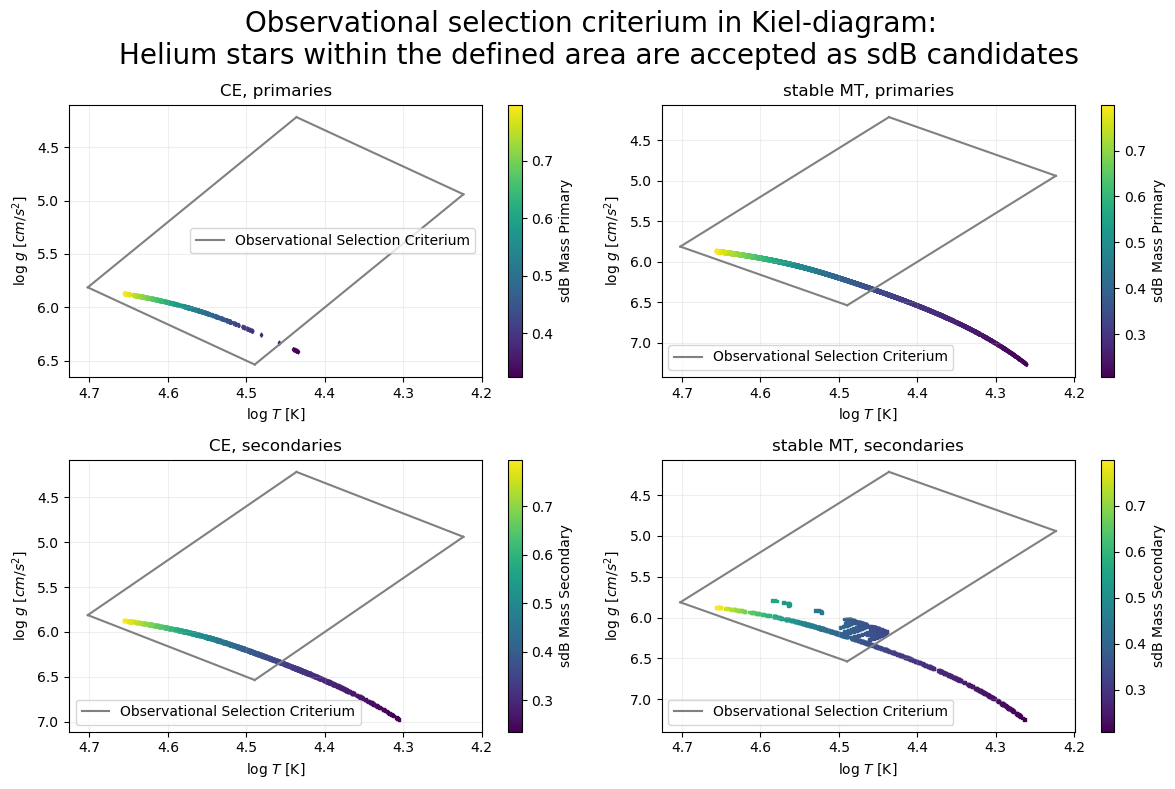

In [32]:
fig, axes = plt.subplots(2,2, figsize=(12,8))

plt.suptitle('Observational selection criterium in Kiel-diagram: \n Helium stars within the defined area are accepted as sdB candidates', fontsize=20)

ax=axes[0][0]
plotKielCriterium('grey')
scatterKiel(ce1, 1)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel(r'log $T$ [K]')
ax.set_ylabel(r'log $g$ [$cm/s^2$]')
ax.set_title('CE, primaries')

ax=axes[1][0]
plotKielCriterium('grey')
scatterKiel(ce2, 2)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel(r'log $T$ [K]')
ax.set_ylabel(r'log $g$ [$cm/s^2$]')
ax.set_title('CE, secondaries')

ax=axes[0][1]
plotKielCriterium('grey')
scatterKiel(stable1, 1)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel(r'log $T$ [K]')
ax.set_ylabel(r'log $g$ [$cm/s^2$]')
ax.set_title('stable MT, primaries')

ax=axes[1][1]
plotKielCriterium('grey')
scatterKiel(stable2, 2)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel(r'log $T$ [K]')
ax.set_ylabel(r'log $g$ [$cm/s^2$]')
ax.set_title('stable MT, secondaries')

plt.tight_layout()
plt.show()

In [33]:
passed_check_sdB_masses = [RLOF['Mass(1)'][ce1][kiel_ce1], RLOF['Mass(2)'][ce2][kiel_ce2], \
                           RLOF['Mass(1)'][stable1][kiel_stable1] , RLOF['Mass(2)'][stable2][kiel_stable2]]
passed_check_sdB_masses1 = [RLOF['Mass(1)'][ce1][kiel_ce1], RLOF['Mass(1)'][stable1][kiel_stable1]]
passed_check_sdB_masses2 = [RLOF['Mass(2)'][ce2][kiel_ce2], RLOF['Mass(2)'][stable2][kiel_stable2]]

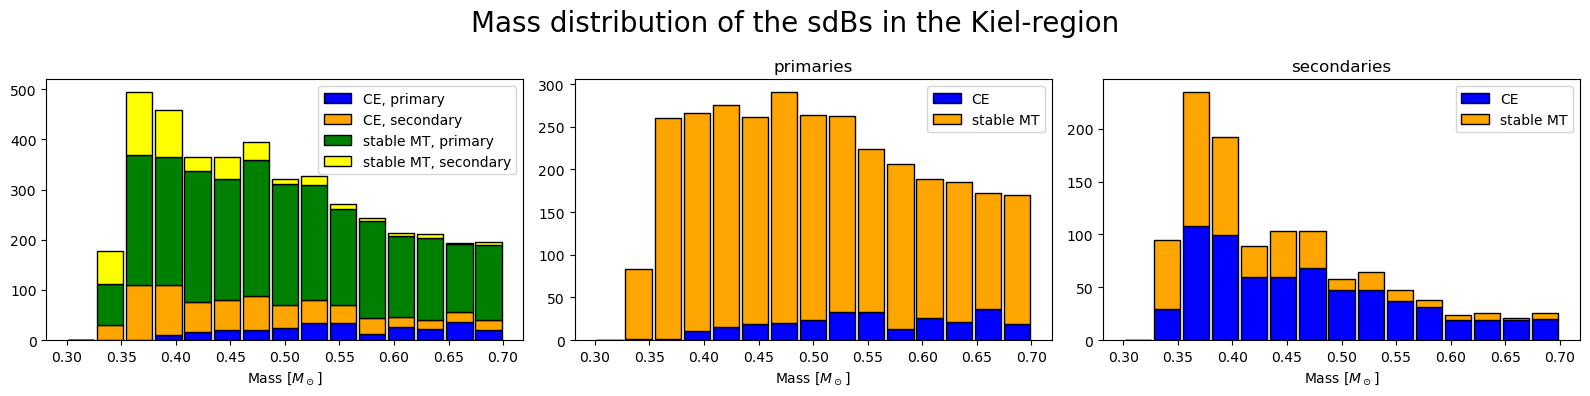

In [34]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

ax=axes[0]
ax.hist(passed_check_sdB_masses, bins=mass_bins, stacked=True, color=['blue', 'orange', 'green', 'yellow'], \
        label=['CE, primary', 'CE, secondary', 'stable MT, primary', 'stable MT, secondary'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_xlabel(r'Mass [$M_\odot$]')

ax=axes[1]
ax.hist(passed_check_sdB_masses1, bins=mass_bins, stacked=True, color=['blue', 'orange'], label=['CE', 'stable MT'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_title('primaries')
ax.set_xlabel(r'Mass [$M_\odot$]')

ax=axes[2]
ax.hist(passed_check_sdB_masses2, bins=mass_bins, stacked=True, color=['blue', 'orange'], label=['CE', 'stable MT'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_title('secondaries')
ax.set_xlabel(r'Mass [$M_\odot$]')

plt.suptitle('Mass distribution of the sdBs in the Kiel-region', fontsize=20)

plt.tight_layout()
plt.show()

## Weighted Histogram by time spent stripped

In [35]:
def getTimeStripped(channel_mask, primary_or_secondary):

    WD = [10,11,12]
    has_fully_evolved1 = np.in1d(SPs['Stellar_Type(1)'][()], WD)
    has_fully_evolved2 = np.in1d(SPs['Stellar_Type(2)'][()], WD)
    
    if (primary_or_secondary==1):
        
        in_channel_and_evolved = np.in1d(SLs['SEED'][()], RLOF['SEED'][channel_mask]) & np.in1d(SLs['SEED'][()], SPs['SEED'][has_fully_evolved1])
        has_evolved = np.in1d(RLOF['SEED'][()], SPs['SEED'][has_fully_evolved1])
        
        stripped = in_channel_and_evolved & (SLs['Star_Switching'][()]==1) & \
        np.in1d(SLs['Switching_From'][()], [2,3,4]) & np.in1d(SLs['Switching_To'][()], [7])
        
        compact_object = in_channel_and_evolved & (SLs['Star_Switching'][()]==1) & \
        np.in1d(SLs['Switching_From'][()], [7,8,9]) & np.in1d(SLs['Switching_To'][()], [10,11,12])

        time_spent_stripped = SLs['Time'][compact_object] - SLs['Time'][stripped]
        sdB_mass = RLOF['Mass(1)>MT'][channel_mask&has_evolved]
        zams_mass = RLOF['Mass@ZAMS(1)'][channel_mask&has_evolved] 
        mass_pre_stripping = RLOF['Mass(1)<MT'][channel_mask&has_evolved] 
        
    if (primary_or_secondary==2):
        
        in_channel_and_evolved = np.in1d(SLs['SEED'][()], RLOF['SEED'][channel_mask]) & np.in1d(SLs['SEED'][()], SPs['SEED'][has_fully_evolved2])
        has_evolved = np.in1d(RLOF['SEED'][()], SPs['SEED'][has_fully_evolved2])
        
        stripped = in_channel_and_evolved & (SLs['Star_Switching'][()]==2) & \
        np.in1d(SLs['Switching_From'][()], [2,3,4]) & np.in1d(SLs['Switching_To'][()], [7])
        
        compact_object = in_channel_and_evolved & (SLs['Star_Switching'][()]==2) & \
        np.in1d(SLs['Switching_From'][()], [7,8,9]) & np.in1d(SLs['Switching_To'][()], [10,11,12])

        time_spent_stripped = SLs['Time'][compact_object] - SLs['Time'][stripped]
        sdB_mass = RLOF['Mass(2)>MT'][channel_mask&has_evolved]
        zams_mass = RLOF['Mass@ZAMS(2)'][channel_mask&has_evolved] 
        mass_pre_stripping = RLOF['Mass(2)<MT'][channel_mask&has_evolved] 
    
    return [sdB_mass, time_spent_stripped, zams_mass, mass_pre_stripping]

In [36]:
kiel_ce1_seeds = RLOF['SEED'][ce1][kiel_ce1]
kiel_ce2_seeds = RLOF['SEED'][ce2][kiel_ce2]
kiel_stable1_seeds = RLOF['SEED'][stable1][kiel_stable1]
kiel_stable2_seeds = RLOF['SEED'][stable2][kiel_stable2]

kiel_ce1_mask = np.in1d(RLOF['SEED'][()], kiel_ce1_seeds) & ce1
kiel_ce2_mask = np.in1d(RLOF['SEED'][()], kiel_ce2_seeds) & ce2
kiel_stable1_mask = np.in1d(RLOF['SEED'][()], kiel_stable1_seeds) & stable1
kiel_stable2_mask = np.in1d(RLOF['SEED'][()], kiel_stable2_seeds) & stable2

In [37]:
time_ce1 = getTimeStripped(kiel_ce1_mask, 1)
time_ce2 = getTimeStripped(kiel_ce2_mask, 2)
time_stable1 = getTimeStripped(kiel_stable1_mask, 1)
time_stable2 = getTimeStripped(kiel_stable2_mask, 2)

In [38]:
time = [time_ce1[1], time_ce2[1], time_stable1[1], time_stable2[1]]
time1 = [time_ce1[1], time_stable1[1]]
time2 = [time_ce2[1], time_stable2[1]]

mass = [time_ce1[0], time_ce2[0], time_stable1[0], time_stable2[0]]
mass1 = [time_ce1[0], time_stable1[0]]
mass2 = [time_ce2[0], time_stable2[0]]

print(len(mass[3]), len(time[3]))

466 285


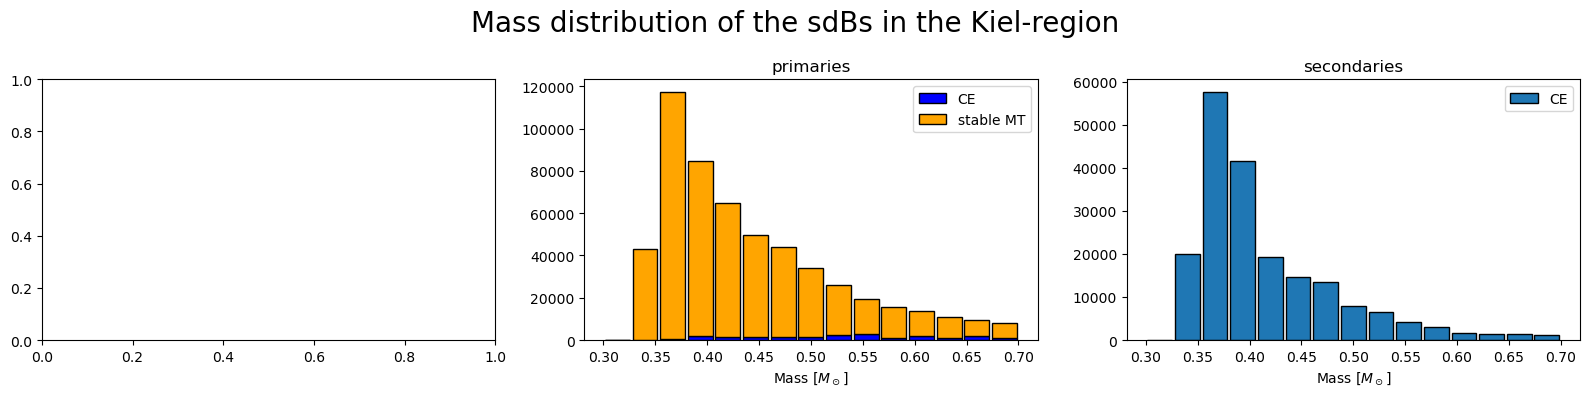

In [39]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

#ax=axes[0]
#ax.hist(mass, weights=time, bins=mass_bins, stacked=True, color=['blue', 'orange', 'green', 'yellow'], \
#        label=['CE, primary', 'CE, secondary', 'stable MT, primary', 'stable MT, secondary'], edgecolor='black', rwidth=0.9)
#ax.legend()
#ax.set_xlabel(r'Mass [$M_\odot$]')

ax=axes[1]
ax.hist(mass1, weights=time1, bins=mass_bins, stacked=True, color=['blue', 'orange'], label=['CE', 'stable MT'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_title('primaries')
ax.set_xlabel(r'Mass [$M_\odot$]')

ax=axes[2]
ax.hist(mass2[0], weights=time2[0], bins=mass_bins, label='CE', edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_title('secondaries')
ax.set_xlabel(r'Mass [$M_\odot$]')

plt.suptitle('Mass distribution of the sdBs in the Kiel-region', fontsize=20)

plt.tight_layout()
plt.show()

## Mass histogram for pre-interaction mass

In [41]:
passed_check_sdB_premasses = [RLOF['Mass@ZAMS(1)'][ce1][kiel_ce1], RLOF['Mass(2)<MT'][ce2][kiel_ce2], \
                           RLOF['Mass@ZAMS(1)'][stable1][kiel_stable1] , RLOF['Mass(2)<MT'][stable2][kiel_stable2]]
passed_check_sdB_premasses1 = [RLOF['Mass@ZAMS(1)'][ce1][kiel_ce1], RLOF['Mass@ZAMS(1)'][stable1][kiel_stable1]]
passed_check_sdB_premasses2 = [RLOF['Mass(2)<MT'][ce2][kiel_ce2], RLOF['Mass(2)<MT'][stable2][kiel_stable2]]

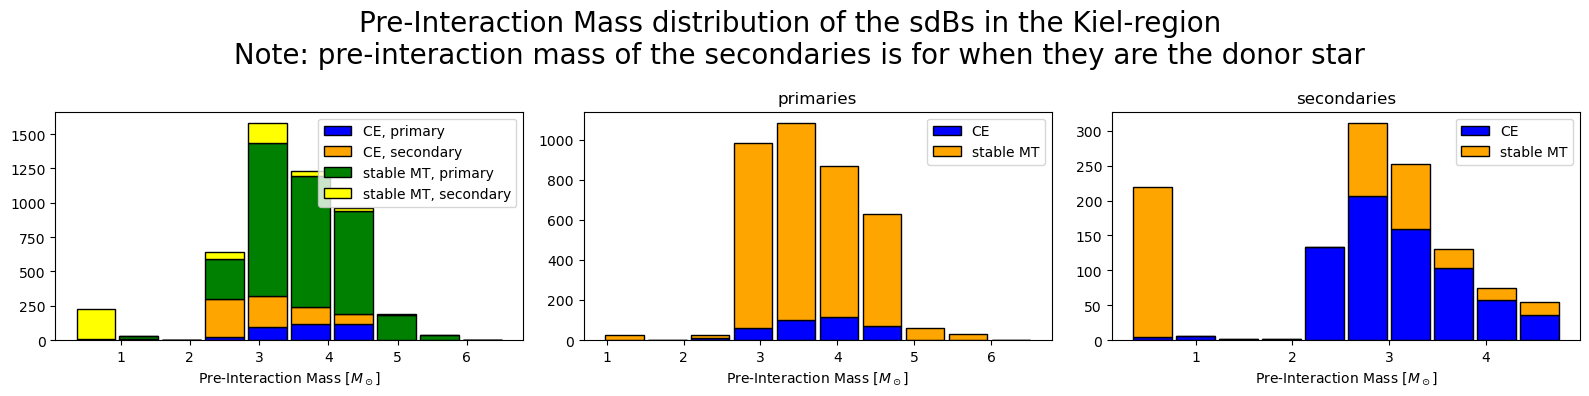

In [42]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

ax=axes[0]
ax.hist(passed_check_sdB_premasses, stacked=True, color=['blue', 'orange', 'green', 'yellow'], \
        label=['CE, primary', 'CE, secondary', 'stable MT, primary', 'stable MT, secondary'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_xlabel(r'Pre-Interaction Mass [$M_\odot$]')

ax=axes[1]
ax.hist(passed_check_sdB_premasses1, stacked=True, color=['blue', 'orange'], label=['CE', 'stable MT'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_title('primaries')
ax.set_xlabel(r'Pre-Interaction Mass [$M_\odot$]')

ax=axes[2]
ax.hist(passed_check_sdB_premasses2, stacked=True, color=['blue', 'orange'], label=['CE', 'stable MT'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_title('secondaries')
ax.set_xlabel(r'Pre-Interaction Mass [$M_\odot$]')

plt.suptitle('Pre-Interaction Mass distribution of the sdBs in the Kiel-region \n Note: pre-interaction mass of the secondaries is for when they are the donor star', fontsize=20)

plt.tight_layout()
plt.show()

## Orbital Period distribution

In [43]:
def logPeriod(channel_mask):
    logP = np.log10( 2*np.pi/np.sqrt(G) * np.sqrt( (RLOF['SemiMajorAxis>MT'][channel_mask])**3 / (RLOF['Mass(1)>MT'][channel_mask]+RLOF['Mass(2)>MT'][channel_mask]) ))
    return logP
def Period(channel_mask):
    logP = 2*np.pi/np.sqrt(G) * np.sqrt( (RLOF['SemiMajorAxis>MT'][channel_mask])**3 / (RLOF['Mass(1)>MT'][channel_mask]+RLOF['Mass(2)>MT'][channel_mask]) )
    return logP

def getPeriods(channel_mask_primary, channel_mask_secondary):
    logP = np.append(logPeriod(channel_mask_primary), logPeriod(channel_mask_secondary))
    return logP 

In [44]:
period_ce1 = logPeriod(kiel_ce1_mask)
period_ce2 = logPeriod(kiel_ce2_mask)
period_stable1 = logPeriod(kiel_stable1_mask)
period_stable2 = logPeriod(kiel_stable2_mask)

periods = [period_ce1, period_ce2, period_stable1, period_stable2]
periods1 = [period_ce1, period_stable1]
periods2 = [period_ce2, period_stable2]

period_bins=np.linspace(-2,4,25)

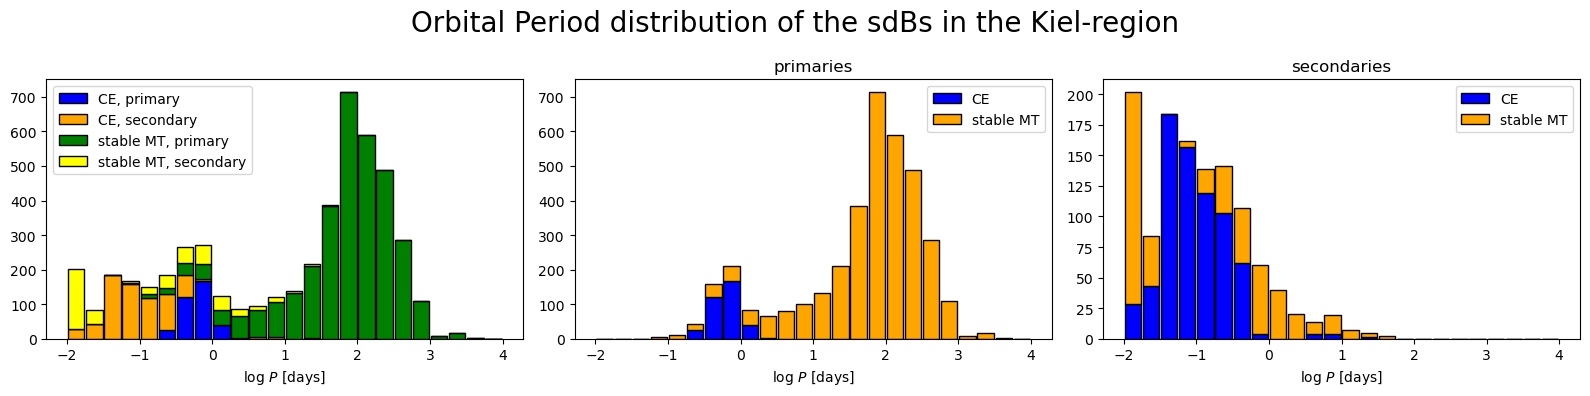

In [45]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

ax=axes[0]
ax.hist(periods, stacked=True, bins=period_bins, color=['blue', 'orange', 'green', 'yellow'], \
        label=['CE, primary', 'CE, secondary', 'stable MT, primary', 'stable MT, secondary'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_xlabel(r'log $P$ [days]')


ax=axes[1]
ax.hist(periods1, stacked=True, bins=period_bins, color=['blue', 'orange'], label=['CE', 'stable MT'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_title('primaries')
ax.set_xlabel(r'log $P$ [days]')


ax=axes[2]
ax.hist(periods2, stacked=True, bins=period_bins, color=['blue', 'orange'], label=['CE', 'stable MT'], edgecolor='black', rwidth=0.9)
ax.legend()
ax.set_title('secondaries')
ax.set_xlabel(r'log $P$ [days]')



plt.suptitle('Orbital Period distribution of the sdBs in the Kiel-region', fontsize=20)

plt.tight_layout()
plt.show()

## Heat map for sdBs
Based on pre- and post-interaction scatterplot.

In [46]:
import seaborn as sns

In [47]:
pre_interaction_masses = np.append(passed_check_sdB_premasses1[0], passed_check_sdB_premasses1[1])
sdB_masses = np.append(passed_check_sdB_masses1[0], passed_check_sdB_masses1[1])

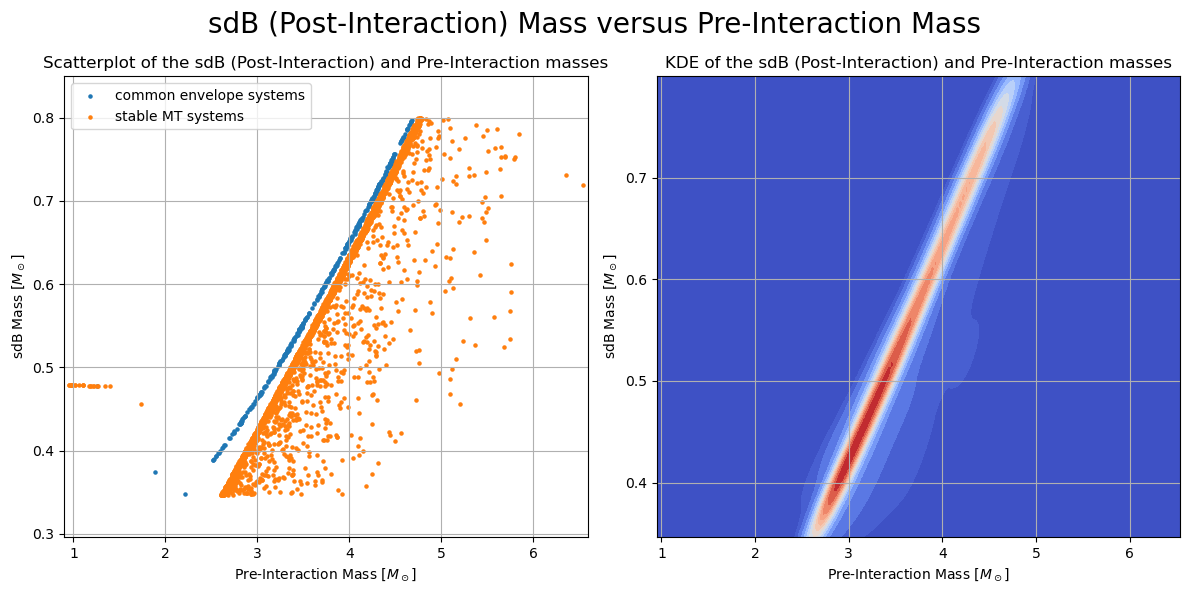

In [54]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

plt.suptitle('sdB (Post-Interaction) Mass versus Pre-Interaction Mass', fontsize=20)

ax=axes[0]
ax.scatter(passed_check_sdB_premasses1[0], passed_check_sdB_masses1[0], s=5, label='common envelope systems')
ax.scatter(passed_check_sdB_premasses1[1], passed_check_sdB_masses1[1], s=5, label='stable MT systems')
ax.legend()
ax.grid()
ax.set_xlabel(r'Pre-Interaction Mass [$M_\odot$]')
ax.set_ylabel(r'sdB Mass [$M_\odot$]')
ax.set_title('Scatterplot of the sdB (Post-Interaction) and Pre-Interaction masses')
ax.set_xlim(np.min(pre_interaction_masses)-0.05, np.max(pre_interaction_masses)+0.05)
ax.set_ylim(np.min(sdB_masses)-0.05, np.max(sdB_masses)+0.05)

ax=axes[1]
sns.kdeplot(x=pre_interaction_masses, y=sdB_masses, cmap="coolwarm", fill=True, levels=15, thresh=0)
ax.set_xlabel(r'Pre-Interaction Mass [$M_\odot$]')
ax.grid()
ax.set_ylabel(r'sdB Mass [$M_\odot$]')
ax.set_title('KDE of the sdB (Post-Interaction) and Pre-Interaction masses')
ax.set_xlim(np.min(pre_interaction_masses), np.max(pre_interaction_masses))
ax.set_ylim(np.min(sdB_masses), np.max(sdB_masses))

plt.tight_layout()
plt.show()

(array([2.960e+02, 1.700e+03, 1.573e+03, 1.929e+03, 2.961e+03, 3.448e+03,
        3.761e+03, 3.347e+03, 3.136e+03, 3.031e+03, 2.974e+03, 2.937e+03,
        2.893e+03, 2.695e+03, 2.595e+03, 2.414e+03, 2.181e+03, 2.122e+03,
        2.000e+03, 1.887e+03, 1.723e+03, 1.641e+03, 1.451e+03, 6.290e+02,
        2.200e+01, 2.200e+01, 1.000e+01, 1.100e+01, 1.000e+01, 8.000e+00,
        5.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+01, 1.000e+01, 6.000e+00, 1.400e+01, 1.800e+01, 1.700e+01,
        2.700e+01, 1.700e+01, 2.100e+01, 1.200e+01, 2.100e+01, 9.000e+00,
        1.700e+01, 1.200e+01, 1.300e+01, 1.300e+01, 1.200e+01, 6.000e+00,
        1.500e+01, 8.000e+00, 1.300e+0

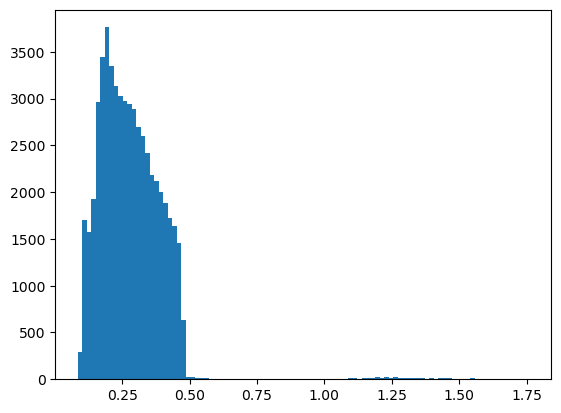

In [49]:
HeWD_mask = (RLOF['Stellar_Type(1)>MT'][()]==10)
plt.hist(RLOF['Mass(1)>MT'][HeWD_mask], bins=100)

In [ ]:
## nicolas code

In [ ]:
def getPQandD(mass, MHeF, logmet):

    outP = []

    outQ = []

    outD = []

    for i in range(len(mass)):

        p = 6

        q = 3

        m = mass[i]

        mhef = MHeF[i]

        lz = logmet[i]

        D0 = 5.37 + 0.135 * lz

        D1 = 0.975 * D0 - 0.18 * m

        logD = D0

        if m > mhef:

            if m >= 2.5:

                p = 5

                q = 2

                D2 = 0.5 * D0 - 0.06 * m

                logD = max(max(-1, D1), D2)

            else:

                gradient = 1 / (mhef - 2.5)

                interceptP = 5 - 2.5 * gradient

                p = gradient * m + interceptP

                interceptQ = 2 - 2.5 * gradient

                q = gradient * m + interceptQ

                gradientQ = gradient * (D0 - D1)

                interceptQ = D0 - mhef * gradientQ

                logD = gradientQ * m + interceptQ

        outP.append(p)

        outQ.append(q)

        outD.append(10**logD)

    return np.array(outP), np.array(outQ), np.array(outD)

def CoreMassFromLuminosity(lum, B, D, q, p, Lx):

    if lum > Lx:

        return (lum/B)**(1/q)

    else:

        return (lum/D)**(1/p)

def getMHeF(logmet, logmet2):

    # logmet = np.log10(metallicity/0.02)

    return 1.995 + 0.25 * logmet + 0.087 * logmet2 #Hurley 2000 eq 2

def getHeIgnition(mass, metallicity):

    logmet = np.log10(metallicity/0.02)

    logmet2 = logmet * logmet

    logmet3 = logmet2 * logmet

    MHeF = getMHeF(logmet, logmet2)

    b9 = 2751.631 + 355.7098 * logmet

    b10 = -0.03820831 + 0.05872664 * logmet

    b11 = 1.071738E2 - 8.970339E1 * logmet - 3.949739E1 * logmet2

    b11 = b11 * b11

    b12 = 7.348793E2 - 1.531020E2 * logmet - 3.7937E1 * logmet2

    b13 = 9.219293 - 2.005865 * logmet - 5.561309 * logmet2 / 10

    b13 = b13 * b13

    b36 = 0.1445216 - 0.06180219* logmet + 0.03093878 * logmet2 + 0.01567090 * logmet3

    b36 = b36 * b36 * b36 * b36

    b37 = 1.304129 + 0.1395919 * logmet + 0.004142455 * logmet2 - 0.009732503 * logmet3

    b37 = 4 * b37

    b38 = 0.5114149 - 0.01160850 * logmet

    b38 = b38 * b38 * b38 * b38

    lum_MHeF = (b11 + (b12 * MHeF**3.8)) / (b13 + MHeF * MHeF)

    p, q, D = getPQandD(mass, MHeF, logmet)

    tot = len(p)

    B = np.array([max(30000, 500 + (17500 * m**0.6)) for m in mass])

    Mx = np.power(B/D, 1/(p-q))

    Lx = np.array([min(B[x] * Mx[x]**q[x], D[x] * Mx[x]**p[x]) for x in range(tot)])

    Mc_MHeF = np.array([CoreMassFromLuminosity(lum_MHeF[x], B[x], D[x], q[x], p[x], Lx[x]) for x in range(tot)])

    McBAGB = b36 * mass**b37 + b38

    C1 = 9.20925E-5

    C2 = 5.402216

    alpha1 = ((b9 * np.power(mass, b10)) - lum_MHeF) / lum_MHeF

    luminosity = (b9 * np.power(mass, b10)) / (1 + (alpha1 * np.exp(15 * (mass - MHeF))))

    C = Mc_MHeF * Mc_MHeF * Mc_MHeF * Mc_MHeF - (C1 * MHeF**C2)

    out = [min(0.95 * McBAGB[x], np.sqrt(np.sqrt(C[x] + C1 * np.power(mass[x], C2)))) if (mass[x] > MHeF[x]) else CoreMassFromLuminosity(luminosity[x], B[x], D[x], q[x], p[x], Lx[x]) for x in range(tot)]

    return np.array(out)

def maskIgnitesOrNot(massesPre, massesPost, metArray):

    expected = getHeIgnition(massesPre, metArray)

    mask3 = np.array([massesPost[x] >= (expected[x] * 0.97) for x in range(len(expected))])

    mask5 = np.array([massesPost[x] >= (expected[x] * 0.95) for x in range(len(expected))])

    return(expected, mask3, mask5)

# Usage

core_mass_at_RGB_tip, within_3_percent, within_5_percent = maskIgnitesOrNot(progenitor_mass, wd_mass, corresponding_metallicities)

#float array, boolean array, boolean array